In [ ]:
#Adapted from the algorithm of Wang et al paper "Unsupervised Representation Learning by Predicting Random Distances” https://arxiv.org/abs/1912.12186
#from code base found at https://github.com/billhhh/RDP/
"""
Author: Bill Wang
"""

'\nAuthor: Bill Wang\n'

In [ ]:
# make two local directories  one named save_model, one named logs
import os
os.mkdir('./save_model')
os.mkdir('./logs')

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q torch==1.10.0 torchvision

In [ ]:
"""
Author: Bill Wang
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from sklearn.utils.random import sample_without_replacement
from sklearn.neighbors import KDTree
import copy


MAX_GRAD_NORM = 0.1  # clip gradient
LR_GAMMA = 0.1
LR_DECAY_EPOCHS = 5000
cos_activation = False

# the init method switch only controls RN
init_method = 'kaiming'
# init_method = 'rn_orthogonal'
# init_method = 'rn_uniform'
# init_method = 'rn_normal'

MAX_INT = np.iinfo(np.int32).max
MAX_FLOAT = np.finfo(np.float32).max


class RTargetNet(nn.Module):
    def __init__(self, in_c, out_c):
        super(RTargetNet, self).__init__()
        # architecture def
        c = in_c
        layers = []

        for h in [out_c]:
            layers.append(nn.Linear(c, h))
            if not cos_activation and init_method != 'rn_orthogonal':
                layers.append(nn.LeakyReLU(inplace=True, negative_slope=2.5e-1))
            c = h

        self.layers = nn.Sequential(*layers)

        # init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if cos_activation:
                    stdv = 1. / math.sqrt(m.weight.size(1))
                    m.weight.data.normal_(std=stdv)
                    if m.bias is not None:
                        # m.bias.data.normal_(std=stdv)
                        m.bias.data.uniform_(0, math.pi)
                elif init_method == 'kaiming':
                    nn.init.kaiming_normal_(m.weight)
                    nn.init.constant_(m.bias, 0.0)
                elif init_method == 'rn_orthogonal':
                    nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                    nn.init.constant_(m.bias, 0.0)
                elif init_method == 'rn_uniform':
                    stdv = 1. / math.sqrt(m.weight.size(1))
                    m.weight.data.uniform_(-stdv, stdv)
                    if m.bias is not None:
                        m.bias.data.uniform_(-stdv, stdv)
                elif init_method == 'rn_normal':
                    stdv = 1. / math.sqrt(m.weight.size(1))
                    m.weight.data.normal_(std=stdv)
                    if m.bias is not None:
                        m.bias.data.normal_(std=stdv)
                else:
                    raise ValueError('could not find init_method %s' % init_method)

    def forward(self, x):
        x = self.layers(x)
        if cos_activation:
            x = torch.cos(x)
        return x


class RNet(nn.Module):
    def __init__(self, in_c, out_c, dropout_r):
        super(RNet, self).__init__()

        # architecture def
        c = in_c
        layers = []

        for h in [out_c]:
            layers.append(nn.Linear(c, h))
            # if not cos_activation:
            if True:
                layers.append(nn.LeakyReLU(negative_slope=2e-1, inplace=True))
            layers.append(nn.Dropout(dropout_r))
            c = h

        self.layers = nn.Sequential(*layers)

        # one more layer than target network for enough capacity
        self.fc2 = nn.Linear(out_c, out_c)

        # init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if True:
                    nn.init.kaiming_normal_(m.weight)
                    nn.init.constant_(m.bias, 0.0)
                else:
                    stdv = 1. / math.sqrt(m.weight.size(1))
                    # m.weight.data.uniform_(-stdv, stdv)
                    m.weight.data.normal_(std=stdv)
                    if m.bias is not None:
                        # m.bias.data.uniform_(-stdv, stdv)
                        m.bias.data.normal_(std=stdv)

    def forward(self, x):
        x = self.layers(x)
        # if cos_activation:
        if False:
            x = torch.cos(x)
        return x


class RDP_Model:
    def __init__(self, in_c, out_c, logfile=None, USE_GPU=False, LR=1e-4, dropout_r=0.2):
        self.r_target_net = RTargetNet(in_c, out_c)
        self.r_net = RNet(in_c, out_c, dropout_r)
        self.USE_GPU = USE_GPU
        self.LR = LR
        self.logfile = logfile

        print(self.r_target_net)
        if self.logfile:
            self.logfile.write(str(self.r_target_net))
        print(self.r_net)
        if self.logfile:
            self.logfile.write(str(self.r_net))

        if USE_GPU:
            self.r_target_net = self.r_target_net.cuda()
            self.r_net = self.r_net.cuda()

        # define optimizer for predict network
        # self.r_net_optim = torch.optim.Adam(self.r_net.parameters(), lr=LR)
        self.r_net_optim = torch.optim.SGD(self.r_net.parameters(), lr=LR, momentum=0.9)

        self.epoch = 0

    def train_model(self, x, epoch):
        self.r_net.train()

        x_random = copy.deepcopy(x)
        np.random.shuffle(x_random)
        x_random = torch.FloatTensor(x_random)
        if self.USE_GPU:
            x_random = x_random.cuda()

        x = torch.FloatTensor(x)

        if self.USE_GPU:
            x = x.cuda()

        if epoch % LR_DECAY_EPOCHS == 0 and self.epoch != epoch:
            self.adjust_learning_rate()
            self.epoch = epoch

        r_target = self.r_target_net(x).detach()
        r_pred = self.r_net(x)
        gap_loss = torch.mean(F.mse_loss(r_pred, r_target, reduction='none'), dim=1).mean()

        r_target_random = self.r_target_net(x_random).detach()
        r_pred_random = self.r_net(x_random)

        xy = (F.normalize(r_target, p=1, dim=1) * F.normalize(r_target_random, p=1, dim=1)).sum(dim=1)
        x_y_ = (F.normalize(r_pred, p=1, dim=1) * F.normalize(r_pred_random, p=1, dim=1)).sum(dim=1)
        pair_wise_loss = F.mse_loss(xy, x_y_)

        loss = gap_loss + pair_wise_loss

        self.r_net_optim.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.r_net.parameters(), MAX_GRAD_NORM)
        self.r_net_optim.step()
        return gap_loss.data.cpu().numpy()

    def eval_model(self, x):
        self.r_net.eval()
        x_random = copy.deepcopy(x)
        np.random.shuffle(x_random)

        x = torch.FloatTensor(x)
        x_random = torch.FloatTensor(x_random)

        if self.USE_GPU:
            x = x.cuda()
            x_random = x_random.cuda()

        r_target = self.r_target_net(x)
        r_pred = self.r_net(x)
        gap_loss = torch.mean(F.mse_loss(r_pred, r_target, reduction='none'), dim=1)

        r_target_random = self.r_target_net(x_random).detach()
        r_pred_random = self.r_net(x_random)

        xy = F.normalize(r_target, p=1, dim=1) * F.normalize(r_target_random, p=1, dim=1)
        x_y_ = F.normalize(r_pred, p=1, dim=1) * F.normalize(r_pred_random, p=1, dim=1)
        pair_wise_loss = torch.mean(F.mse_loss(xy, x_y_, reduction='none'), dim=1)
        scores = gap_loss + pair_wise_loss
        return scores.data.cpu().numpy()

    def eval_model_lesinn(self, x):
        self.r_net.eval()
        x = torch.FloatTensor(x)

        if self.USE_GPU:
            x = x.cuda()

        r_pred = self.r_net(x)
        scores = self.lesinn(r_pred.data.cpu().numpy())
        return scores.squeeze()

    def lesinn(self, x_train):
        rng = np.random.RandomState(42)
        ensemble_size = 50
        subsample_size = 8
        scores = np.zeros([x_train.shape[0], 1])
        # for reproductibility purpose
        seeds = rng.randint(MAX_INT, size=ensemble_size)
        for i in range(0, ensemble_size):
            rs = np.random.RandomState(seeds[i])
            #        sid = np.random.choice(x_train.shape[0], subsample_size)
            sid = sample_without_replacement(n_population=x_train.shape[0], n_samples=subsample_size, random_state=rs)
            subsample = x_train[sid]
            kdt = KDTree(subsample, metric='euclidean')
            dists, indices = kdt.query(x_train, k=1)
            scores += dists
        scores = scores / ensemble_size
        return scores

    def adjust_learning_rate(self):
        self.LR *= LR_GAMMA
        print(' * adjust C_LR == {}'.format(self.LR))
        if self.logfile:
            self.logfile.write(' * adjust C_LR == {}\n'.format(self.LR))

        for param_group in self.r_net_optim.param_groups:
            param_group['lr'] = self.LR

    def save_model(self, path):
        dict_to_save = {
            'r_net': self.r_net.state_dict(),
            'r_target_net': self.r_target_net.state_dict(),
            # 'r_net_optim': self.r_net_optim,
            # 'LR': self.LR,
        }
        torch.save(dict_to_save, path)

    def load_model(self, name):
        states = torch.load(name)
        self.r_net.load_state_dict(states['r_net'])
        self.r_target_net.load_state_dict(states['r_target_net'])
        if 'r_net_optim' in states:
            self.r_net_optim = states['r_net_optim']
        if 'LR' in states:
            self.LR = states['LR']


In [ ]:
import pandas as pd
import random

from sklearn.datasets import load_svmlight_file
from sklearn.metrics import average_precision_score, roc_auc_score

import time
import datetime



def dataLoading(path, logfile=None):

    # loading data
    df = pd.read_csv(path)
    labels = df['class']
    x_df = df.drop(['class'], axis=1)
    x = x_df.values
    print("Data shape: (%d, %d)" % x.shape)
    if logfile:
        logfile.write("Data shape: (%d, %d)\n" % x.shape)

    return x, labels


# random sampling with replacement
def random_list(start, stop, length):
    if length >= 0:
        length = int(length)
    start, stop = (int(start), int(stop)) if start <= stop else (int(stop), int(start))
    random_list = []
    for i in range(length):
        random_list.append(random.randint(start, stop))  # including start and stop
    return random_list


def writeResults(path, name, roc_auc, average_precision_score ):    
    csv_file = open(path, 'a') 
    row = name + "," + str(roc_auc)+ ","  + str(average_precision_score) +"\n"
    csv_file.write(row)

def aucPerformance(scores, labels, output, dataset_name, logfile=None):
    roc_auc = roc_auc_score(labels, scores)
#    print(roc_auc)
    ap = average_precision_score(labels, scores)
    print("AUC-ROC: %.4f, AUC-PR: %.4f" % (roc_auc, ap))
    writeResults(output, dataset_name, roc_auc, ap)

    if logfile:
        logfile.write("AUC-ROC: %.4f, AUC-PR: %.4f\n" % (roc_auc, ap))

#    plt.title('Receiver Operating Characteristic')
#    plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
#    plt.legend(loc='lower right')
#    plt.plot([0,1],[0,1],'r--')
#    plt.xlim([-0.001, 1])
#    plt.ylim([0, 1.001])
#    plt.ylabel('True Positive Rate')
#    plt.xlabel('False Positive Rate')
#    plt.show();

    return roc_auc, ap


def tic_time():
    print("=====================================================")
    tic_datetime = datetime.datetime.now()
    print("tic_datetime:", tic_datetime)
    print("tic_datetime.strftime:", tic_datetime.strftime('%Y-%m-%d %H:%M:%S.%f'))
    tic_walltime = time.time()
    print("tic_walltime:", tic_walltime)
    tic_cpu = time.clock()
    print("tic_cpu:", tic_cpu)
    print("=====================================================\n")


In [ ]:


#from model import RDP_Model  #running in notebook
import numpy as np
import random
import os
#from util import random_list, aucPerformance #running in notebook

is_batch_replace = True
is_eval = False
test_1l_only = True


class RDPTree():
    def __init__(self,
                 t_id,
                 tree_depth,
                 filter_ratio=0.1):

        self.t_id = t_id
        self.tree_depth = tree_depth
        self.filter_ratio = filter_ratio
        self.thresh = []

    # include train and eval
    def training_process(self,
                         x,
                         labels,
                         batch_size,
                         node_batch,
                         node_epoch,
                         eval_interval,
                         out_c,
                         USE_GPU,
                         LR,
                         save_path,
                         logfile=None,
                         dropout_r=0.1,
                         svm_flag=False,
                         ):
        if svm_flag:
            x_ori = x.toarray()
        else:
            x_ori = x
        labels_ori = labels
        x_level = np.zeros(x_ori.shape[0])
        for level in range(1, self.tree_depth+1):

            # form x and labels
            keep_pos = np.where(x_level == 0)
            x = x_ori[keep_pos]
            labels = labels_ori[keep_pos]
            group_num = int(x.shape[0] / batch_size) + 1
            batch_x = np.array_split(x, group_num)
            model = RDP_Model(in_c=x.shape[1], out_c=out_c, USE_GPU=USE_GPU,
                            LR=LR, logfile=logfile, dropout_r=dropout_r)
            best_auc = best_epoch = 0

            for epoch in range(0, node_epoch):
                if not is_batch_replace:
                    random.shuffle(batch_x)
                    batch_cnt = 0
                    for batch_i in batch_x:
                        gap_loss = model.train_model(batch_i, epoch)
                        # print("epoch ", epoch, "loss: ", loss)
                        batch_cnt += 1
                        if batch_cnt >= node_batch:
                            break

                else:
                    # random sampling with replacement
                    for batch_i in range(node_batch):
                        random_pos = random_list(0, x.shape[0] - 1, batch_size)
                        batch_data = x[random_pos]
                        gap_loss = model.train_model(batch_data, epoch)

                if epoch % eval_interval == 0:
                    # print("epoch ", epoch, "gap_loss:", gap_loss, " recon_loss:", recon_loss)
                    # if logfile:
                    #     logfile.write("epoch " + str(epoch) + " gap_loss: " + str(gap_loss) +
                    #                   " recon_loss: " + str(recon_loss) + '\n')

                    print("tree_id:", self.t_id, "level:", level)
                    print("keep_pos.size ==", keep_pos[0].size)
                    if logfile:
                        logfile.write("tree_id: " + str(self.t_id) + " level: " + str(level)
                                      + "keep_pos.size == " + str(keep_pos[0].size) + '\n')
                    print("epoch ", epoch, "gap_loss:", gap_loss)
                    if logfile:
                        logfile.write("epoch " + str(epoch) + " gap_loss: " + str(gap_loss) + '\n')
                    model.save_model(save_path + 't' + str(self.t_id) + '_l' + str(level) + '_latest.h5')

                    scores = model.eval_model(x)

                    # eval
                    if is_eval:
                        try:
                            roc_auc, ap = aucPerformance(scores, labels, logfile)
                            if roc_auc > best_auc:
                                best_auc = roc_auc
                                best_epoch = epoch

                            print("Best AUC-ROC: %.4f" % best_auc)
                            if logfile:
                                logfile.write("Best AUC-ROC: %.4f\n" % best_auc)
                            print("Best Epoch %d\n" % best_epoch)
                            if logfile:
                                logfile.write("Best Epoch %d\n\n" % best_epoch)
                        except ValueError:
                            print("Only one class present in y_true. ROC AUC score is not defined in that case.")

                    if logfile:
                        logfile.flush()

            # filter anomaly elements. the higher the scores are, the more abnormal
            ranking_scores = scores
            score_ranking_idx = np.argsort(ranking_scores)
            filter_num = int(self.filter_ratio * score_ranking_idx.size)
            filter_idx = score_ranking_idx[score_ranking_idx.size-filter_num:]
            x_level[keep_pos[0][filter_idx]] = self.tree_depth+1 - level
            self.thresh.append(ranking_scores[score_ranking_idx[score_ranking_idx.size-filter_num]])

            # epoch for
        # level for

        # save self.thresh
        filename = save_path + 'threshList_t' + str(self.t_id) + '.txt'
        list_save(self.thresh, filename, 'w')

    def testing_process(self,
                        x,
                        out_c,
                        USE_GPU,
                        load_path,
                        dropout_r,
                        testing_method='last_layer',
                        svm_flag=False,
                        ):

        if svm_flag:
            x_ori = x.toarray()
        else:
            x_ori = x
        x_level = np.zeros(x_ori.shape[0])
        self.thresh = list_read(load_path + 'threshList_t' + str(self.t_id) + '.txt')
        for level in range(1, self.tree_depth + 1):
            # form x
            keep_pos = np.where(x_level == 0)
            x = x_ori[keep_pos]
            model = RDP_Model(in_c=x.shape[1], out_c=out_c, USE_GPU=USE_GPU,
                            dropout_r=dropout_r)
            
            if testing_method == 'last_layer':
                # high --> low load
                model.load_model(
                    load_path + 't' + str(self.t_id) + '_l' + str(self.tree_depth + 1 - level) + '_latest.h5')
            else:
                # low --> high load
                model.load_model(load_path + 't' + str(self.t_id) + '_l' + str(level) + '_latest.h5')

            # eval
            scores = model.eval_model(x)

            if level == 1:
                first_level_scores = scores
                if test_1l_only and testing_method != 'level':
                    return x_level, first_level_scores
            # filter elements
            if testing_method == 'last_layer':
                filter_idx = np.where(scores >= float(self.thresh[self.tree_depth + 1 - level - 1]))
            else:
                filter_idx = np.where(scores >= float(self.thresh[level-1]))
            x_level[keep_pos[0][filter_idx]] = self.tree_depth+1 - level

        return x_level, first_level_scores


def list_save(content, filename, mode='a'):
    # Try to save a list variable in txt file.
    file = open(filename, mode)
    for i in range(len(content)):
        file.write(str(content[i])+'\n')
    file.close()


def list_read(filename):
    # Try to read a txt file and return a list. Return [] if there was a mistake.
    try:
        file = open(filename, 'r')
    except IOError:
        error = []
        return error
    content = file.readlines()

    for i in range(len(content)):
        content[i] = content[i][:len(content[i]) - 1]

    file.close()
    return content


In [ ]:
# this the cell equivalent to train.py
import datetime
import platform
#from rdp_tree import RDPTree  #running in notebook
import shutil
import os
import sys
#from util import dataLoading, random_list, tic_time  #running in notebook
import time
import torch





def train():
    global random_size

    shutil.rmtree(save_path)
    os.mkdir(save_path)

    svm_flag = False
    if 'svm' in data_path:
        svm_flag = True
        from util import get_data_from_svmlight_file
        x_ori, labels_ori = get_data_from_svmlight_file(data_path)
        random_size = 1024
    else:
        x_ori, labels_ori = dataLoading(data_path, logfile)
    data_size = labels_ori.size

    # build forest
    forest = []
    for i in range(forest_Tnum):
        forest.append(RDPTree(t_id=i+1,
                              tree_depth=tree_depth,
                              filter_ratio=filter_ratio,
                              ))

    print("Init tic time.")
    tic_time()

    # training process
    for i in range(forest_Tnum):

        # random sampling with replacement
        random_pos = random_list(0, data_size-1, random_size)
        # random sampling without replacement
        # random_pos = random.sample(range(0, data_size), random_size)

        # to form x and labels
        x = x_ori[random_pos]
        if svm_flag:
            labels = labels_ori[random_pos]
        else:
            labels = labels_ori[random_pos].values

        print("tree id:", i, "tic time.")
        tic_time()

        forest[i].training_process(
            x=x,
            labels=labels,
            batch_size=batch_size,
            node_batch=node_batch,
            node_epoch=node_epoch,
            eval_interval=eval_interval,
            out_c=out_c,
            USE_GPU=USE_GPU,
            LR=LR,
            save_path=save_path,
            logfile=logfile,
            dropout_r=dropout_r,
            svm_flag=svm_flag,
        )

        print("tree id:", i, "tic time end.")
        tic_time()



In [ ]:
# this cell is equivalent to test.py
"""
Author: Bill Wang
"""

import datetime
import platform
import time

#from rdp_tree import RDPTree  # running in notebook
import numpy as np
import sys
#from util import dataLoading, aucPerformance, tic_time  #running in notebook
import torch
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt




def plotAUCPRCurve(y_test, y_score):
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    fig = plt.figure()
    plt.plot(recall, precision)
    fig.suptitle('RDP AUC-PR Thyroid', fontsize=20)
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=16)
    plt.show()

    # Data to plot precision - recall curve
    # PrecisionRecallDisplay.from_predictions(y_test, y_score)
    # RocCurveDisplay.from_predictions( y_test, y_score)
    fpr, tpr, thresholds=roc_curve(y_test, y_score)
    fig = plt.figure()
    plt.plot(fpr, tpr)
    fig.suptitle('RPD AUC-ROC Thyroid', fontsize=20)
    plt.xlabel('FPR', fontsize=18)
    plt.ylabel('TPR', fontsize=16)
    plt.show()

def test(output, dataset_name):
    svm_flag = False
    if 'svm' in data_path:
        svm_flag = True
        from util import get_data_from_svmlight_file
        x, labels = get_data_from_svmlight_file(data_path)
    else:
        x, labels = dataLoading(data_path)
    data_size = labels.size

    # build forest
    forest = []
    for i in range(forest_Tnum):
        forest.append(RDPTree(t_id=i+1,
                              tree_depth=tree_depth,
                              ))

    sum_result = np.zeros(data_size, dtype=np.float64)

    print("Init tic time.")
    tic_time()

    # testing process
    for i in range(forest_Tnum):

        print("tree id:", i, "tic time.")
        tic_time()

        x_level, first_level_scores = forest[i].testing_process(
            x=x,
            out_c=out_c,
            USE_GPU=USE_GPU,
            load_path=load_path,
            dropout_r=dropout_r,
            testing_method=testing_methods_set[testing_method - 1],
            svm_flag=svm_flag,
        )

        if testing_methods_set[testing_method - 1] == 'level':
            sum_result += x_level
        else:
            sum_result += first_level_scores

        print("tree id:", i, "tic time.")
        tic_time()

        if i==0:
            plotAUCPRCurve(labels, sum_result)  #y_test, y_score)
        else:
            plotAUCPRCurve(labels, sum_result/forest_Tnum)  # y_test, y_score)
    scores = sum_result / forest_Tnum
    aucPerformance(scores, labels, output, dataset_name)



Running in DEV_MODE!
for this run the data being analyzed is  gdrive/MyDrive/data/CreditCardSyntheticCauchy/cc_synthetic_cauchy_mn_scale_0.5_cov_scale_1.csv
Data shape: (284807, 29)
Init tic time.
tic_datetime: 2021-12-10 16:17:37.954137
tic_datetime.strftime: 2021-12-10 16:17:37.954137
tic_walltime: 1639153057.9543266
tic_cpu: 17.666282

tree id: 0 tic time.
tic_datetime: 2021-12-10 16:17:37.988577
tic_datetime.strftime: 2021-12-10 16:17:37.988577
tic_walltime: 1639153057.98939
tic_cpu: 17.705571

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Streaming output truncated to the last 5000 lines.
keep_pos.size == 8146
epoch  96 gap_loss: 0.050251674
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  120 gap_loss: 0.05227442
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  144 gap_loss: 0.053539764
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  168 gap_loss: 0.05049621
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  192 gap_loss: 0.04943352
RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)
tree_id: 16 level: 6
keep_pos.size == 7739
epoch  0 gap_loss: 0.14471506
tree_id: 16 level: 6
keep_pos.size == 7739
epoch  24 gap_loss: 0.04254526
tree_id: 16 level: 6
keep_pos.size == 7739


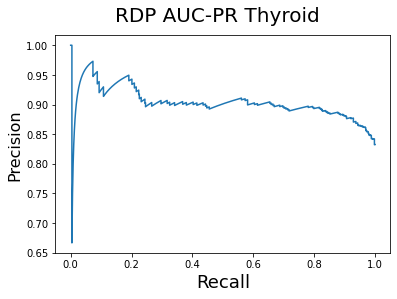

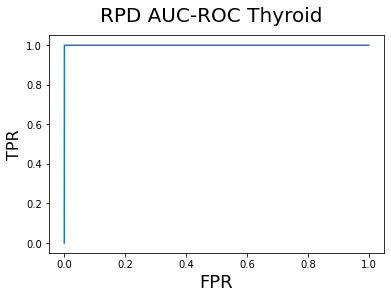

tree id: 1 tic time.
tic_datetime: 2021-12-10 17:22:22.020033
tic_datetime.strftime: 2021-12-10 17:22:22.020033
tic_walltime: 1639156942.020877
tic_cpu: 3903.714906

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 1 tic time.
tic_datetime: 2021-12-10 17:22:23.133978
tic_datetime.strftime: 2021-12-10 17:22:23.133978
tic_walltime: 1639156943.1344204
tic_cpu: 3904.821696



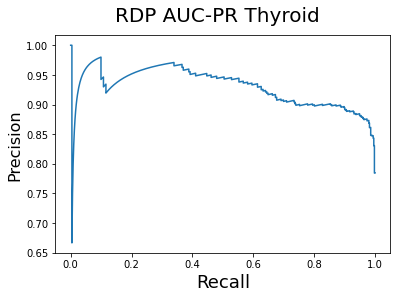

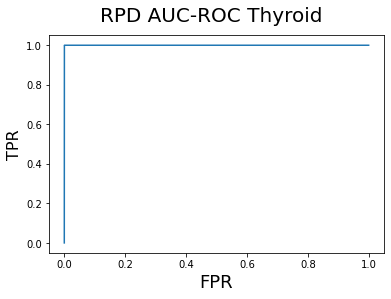

tree id: 2 tic time.
tic_datetime: 2021-12-10 17:22:23.587835
tic_datetime.strftime: 2021-12-10 17:22:23.587835
tic_walltime: 1639156943.587966
tic_cpu: 3905.26848

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 2 tic time.
tic_datetime: 2021-12-10 17:22:24.680406
tic_datetime.strftime: 2021-12-10 17:22:24.680406
tic_walltime: 1639156944.6811783
tic_cpu: 3906.367122



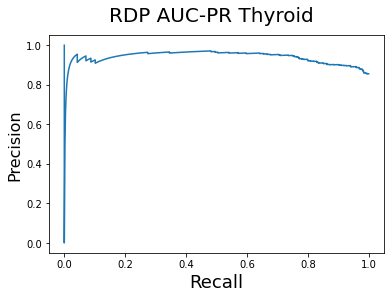

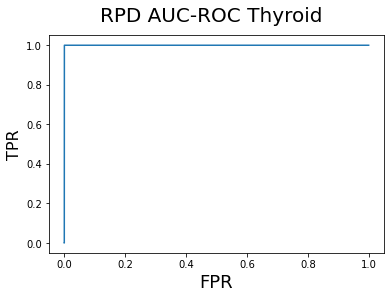

tree id: 3 tic time.
tic_datetime: 2021-12-10 17:22:25.138919
tic_datetime.strftime: 2021-12-10 17:22:25.138919
tic_walltime: 1639156945.1390648
tic_cpu: 3906.831465

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 3 tic time.
tic_datetime: 2021-12-10 17:22:26.247596
tic_datetime.strftime: 2021-12-10 17:22:26.247596
tic_walltime: 1639156946.247752
tic_cpu: 3907.937555



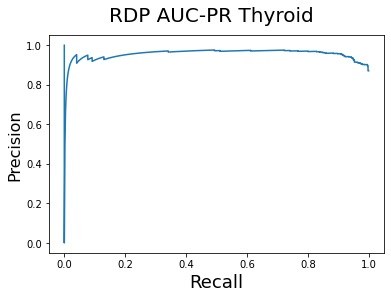

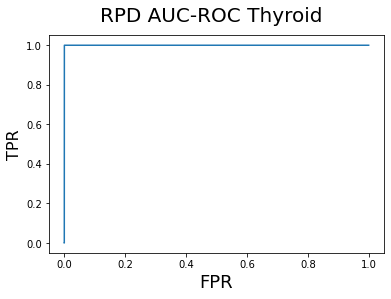

tree id: 4 tic time.
tic_datetime: 2021-12-10 17:22:26.801783
tic_datetime.strftime: 2021-12-10 17:22:26.801783
tic_walltime: 1639156946.802148
tic_cpu: 3908.495737

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 4 tic time.
tic_datetime: 2021-12-10 17:22:27.914140
tic_datetime.strftime: 2021-12-10 17:22:27.914140
tic_walltime: 1639156947.9149835
tic_cpu: 3909.613043



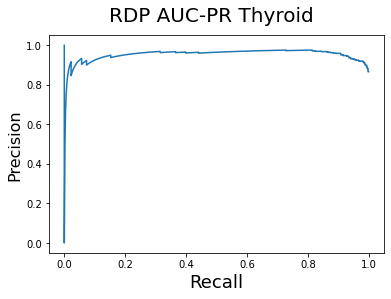

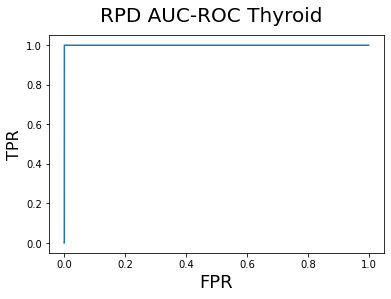

tree id: 5 tic time.
tic_datetime: 2021-12-10 17:22:28.363686
tic_datetime.strftime: 2021-12-10 17:22:28.363686
tic_walltime: 1639156948.3649206
tic_cpu: 3910.066034

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 5 tic time.
tic_datetime: 2021-12-10 17:22:29.486870
tic_datetime.strftime: 2021-12-10 17:22:29.486870
tic_walltime: 1639156949.4876509
tic_cpu: 3911.187558



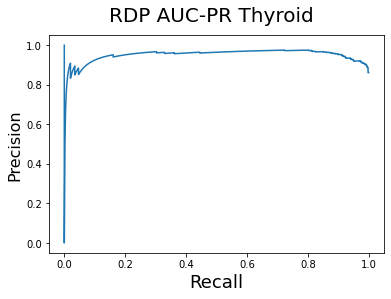

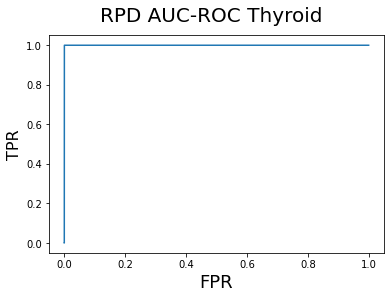

tree id: 6 tic time.
tic_datetime: 2021-12-10 17:22:29.923521
tic_datetime.strftime: 2021-12-10 17:22:29.923521
tic_walltime: 1639156949.9238706
tic_cpu: 3911.623671

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 6 tic time.
tic_datetime: 2021-12-10 17:22:31.039456
tic_datetime.strftime: 2021-12-10 17:22:31.039456
tic_walltime: 1639156951.0396154
tic_cpu: 3912.73397



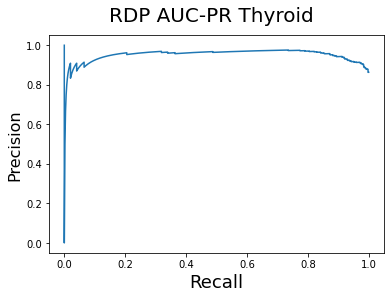

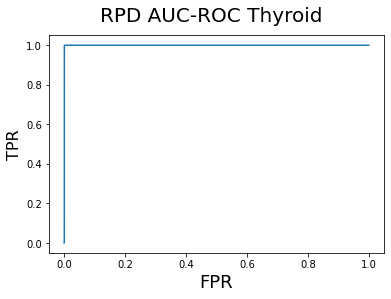

tree id: 7 tic time.
tic_datetime: 2021-12-10 17:22:31.502335
tic_datetime.strftime: 2021-12-10 17:22:31.502335
tic_walltime: 1639156951.5025089
tic_cpu: 3913.201236

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 7 tic time.
tic_datetime: 2021-12-10 17:22:32.611959
tic_datetime.strftime: 2021-12-10 17:22:32.611959
tic_walltime: 1639156952.6121247
tic_cpu: 3914.317168



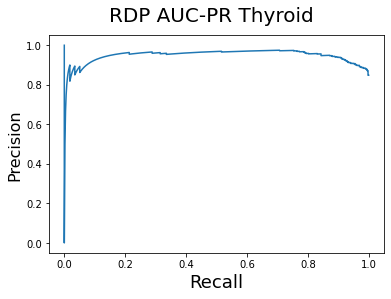

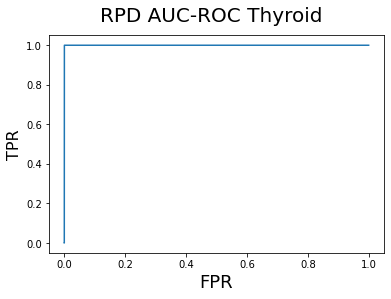

tree id: 8 tic time.
tic_datetime: 2021-12-10 17:22:33.087958
tic_datetime.strftime: 2021-12-10 17:22:33.087958
tic_walltime: 1639156953.088085
tic_cpu: 3914.797247

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 8 tic time.
tic_datetime: 2021-12-10 17:22:34.202029
tic_datetime.strftime: 2021-12-10 17:22:34.202029
tic_walltime: 1639156954.202184
tic_cpu: 3915.914336



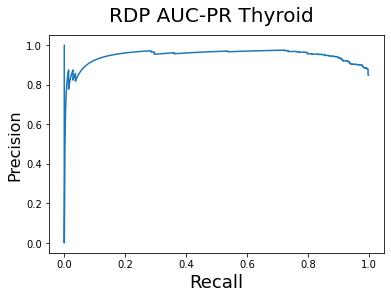

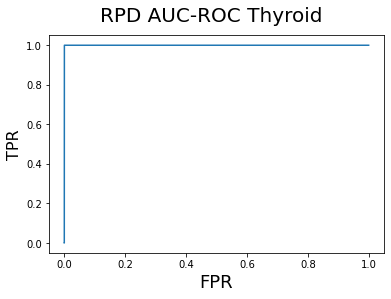

tree id: 9 tic time.
tic_datetime: 2021-12-10 17:22:34.655623
tic_datetime.strftime: 2021-12-10 17:22:34.655623
tic_walltime: 1639156954.6557403
tic_cpu: 3916.360139

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 9 tic time.
tic_datetime: 2021-12-10 17:22:35.770519
tic_datetime.strftime: 2021-12-10 17:22:35.770519
tic_walltime: 1639156955.7706845
tic_cpu: 3917.47327



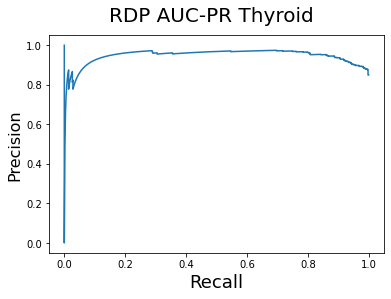

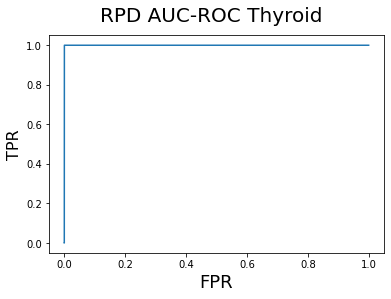

tree id: 10 tic time.
tic_datetime: 2021-12-10 17:22:36.235925
tic_datetime.strftime: 2021-12-10 17:22:36.235925
tic_walltime: 1639156956.2360725
tic_cpu: 3917.93551

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 10 tic time.
tic_datetime: 2021-12-10 17:22:37.352344
tic_datetime.strftime: 2021-12-10 17:22:37.352344
tic_walltime: 1639156957.352527
tic_cpu: 3919.045282



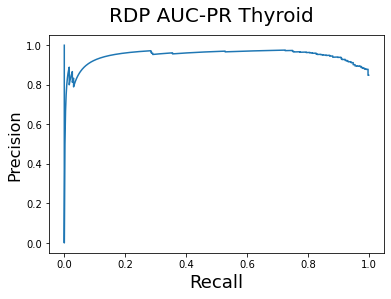

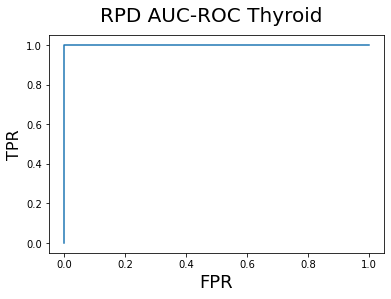

tree id: 11 tic time.
tic_datetime: 2021-12-10 17:22:37.795437
tic_datetime.strftime: 2021-12-10 17:22:37.795437
tic_walltime: 1639156957.7955656
tic_cpu: 3919.489986

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 11 tic time.
tic_datetime: 2021-12-10 17:22:38.910999
tic_datetime.strftime: 2021-12-10 17:22:38.910999
tic_walltime: 1639156958.9118044
tic_cpu: 3920.606614



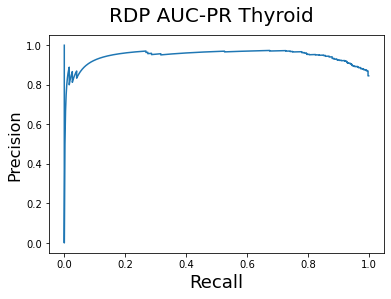

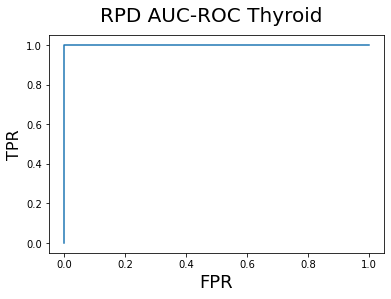

tree id: 12 tic time.
tic_datetime: 2021-12-10 17:22:39.381687
tic_datetime.strftime: 2021-12-10 17:22:39.381687
tic_walltime: 1639156959.3829918
tic_cpu: 3921.069474

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 12 tic time.
tic_datetime: 2021-12-10 17:22:40.486484
tic_datetime.strftime: 2021-12-10 17:22:40.486484
tic_walltime: 1639156960.486661
tic_cpu: 3922.169605



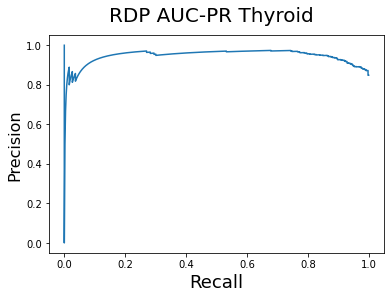

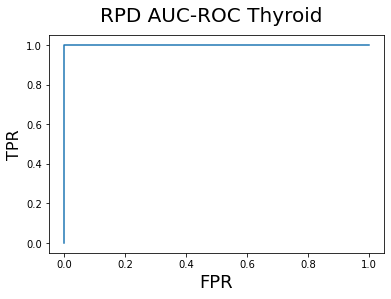

tree id: 13 tic time.
tic_datetime: 2021-12-10 17:22:40.928972
tic_datetime.strftime: 2021-12-10 17:22:40.928972
tic_walltime: 1639156960.9291177
tic_cpu: 3922.613556

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 13 tic time.
tic_datetime: 2021-12-10 17:22:42.068146
tic_datetime.strftime: 2021-12-10 17:22:42.068146
tic_walltime: 1639156962.0689948
tic_cpu: 3923.741387



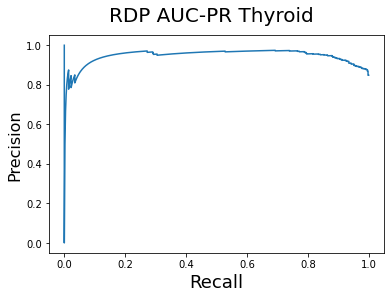

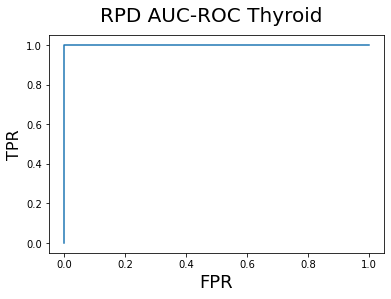

tree id: 14 tic time.
tic_datetime: 2021-12-10 17:22:42.528959
tic_datetime.strftime: 2021-12-10 17:22:42.528959
tic_walltime: 1639156962.5306308
tic_cpu: 3924.197144

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 14 tic time.
tic_datetime: 2021-12-10 17:22:43.634704
tic_datetime.strftime: 2021-12-10 17:22:43.634704
tic_walltime: 1639156963.634861
tic_cpu: 3925.298579



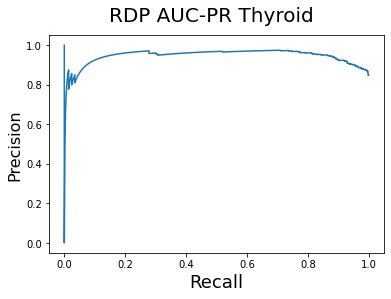

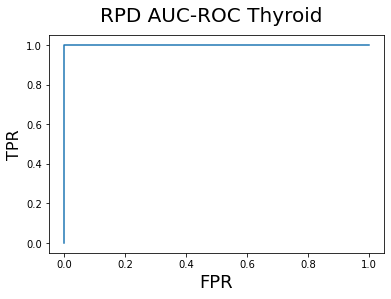

tree id: 15 tic time.
tic_datetime: 2021-12-10 17:22:44.233024
tic_datetime.strftime: 2021-12-10 17:22:44.233024
tic_walltime: 1639156964.2331429
tic_cpu: 3925.898383

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 15 tic time.
tic_datetime: 2021-12-10 17:22:45.346325
tic_datetime.strftime: 2021-12-10 17:22:45.346325
tic_walltime: 1639156965.3464925
tic_cpu: 3927.014881



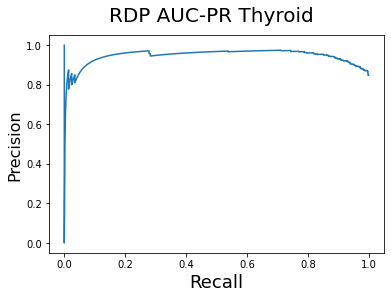

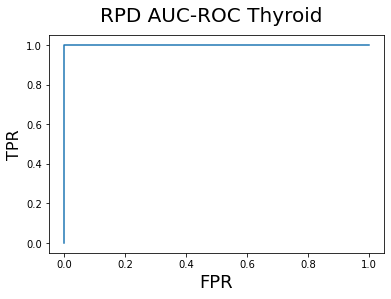

tree id: 16 tic time.
tic_datetime: 2021-12-10 17:22:45.794371
tic_datetime.strftime: 2021-12-10 17:22:45.794371
tic_walltime: 1639156965.794515
tic_cpu: 3927.466388

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 16 tic time.
tic_datetime: 2021-12-10 17:22:46.901532
tic_datetime.strftime: 2021-12-10 17:22:46.901532
tic_walltime: 1639156966.901701
tic_cpu: 3928.573385



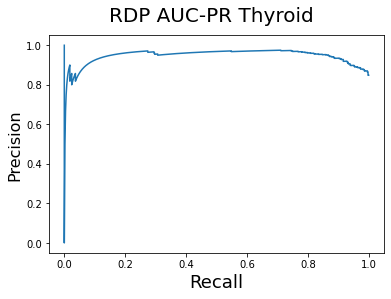

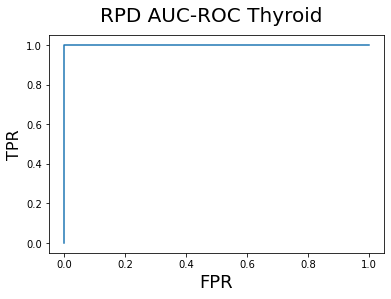

tree id: 17 tic time.
tic_datetime: 2021-12-10 17:22:47.359218
tic_datetime.strftime: 2021-12-10 17:22:47.359218
tic_walltime: 1639156967.3593824
tic_cpu: 3929.04146

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 17 tic time.
tic_datetime: 2021-12-10 17:22:48.477030
tic_datetime.strftime: 2021-12-10 17:22:48.477030
tic_walltime: 1639156968.4771953
tic_cpu: 3930.167134



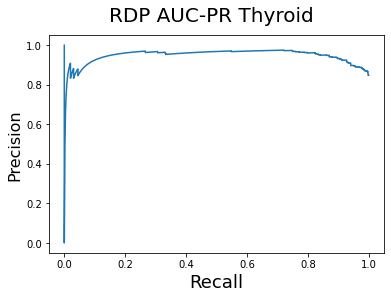

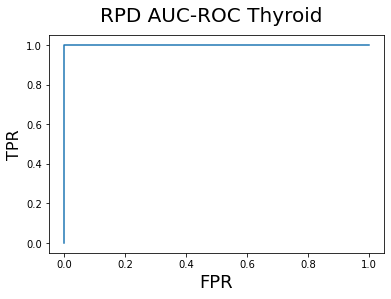

tree id: 18 tic time.
tic_datetime: 2021-12-10 17:22:48.925195
tic_datetime.strftime: 2021-12-10 17:22:48.925195
tic_walltime: 1639156968.925343
tic_cpu: 3930.613889

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 18 tic time.
tic_datetime: 2021-12-10 17:22:50.037288
tic_datetime.strftime: 2021-12-10 17:22:50.037288
tic_walltime: 1639156970.0374448
tic_cpu: 3931.734719



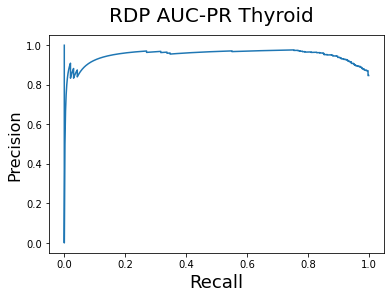

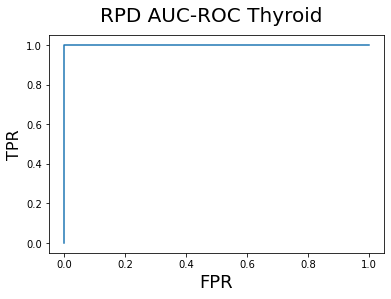

tree id: 19 tic time.
tic_datetime: 2021-12-10 17:22:50.496617
tic_datetime.strftime: 2021-12-10 17:22:50.496617
tic_walltime: 1639156970.4970767
tic_cpu: 3932.198496

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 19 tic time.
tic_datetime: 2021-12-10 17:22:51.616757
tic_datetime.strftime: 2021-12-10 17:22:51.616757
tic_walltime: 1639156971.616926
tic_cpu: 3933.326951



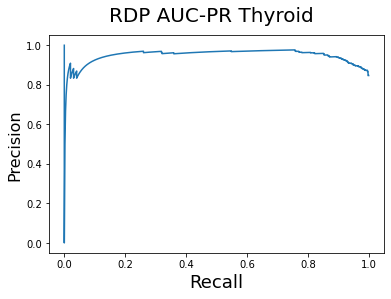

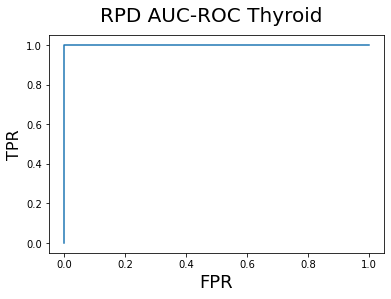

tree id: 20 tic time.
tic_datetime: 2021-12-10 17:22:52.065734
tic_datetime.strftime: 2021-12-10 17:22:52.065734
tic_walltime: 1639156972.0661695
tic_cpu: 3933.769654

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 20 tic time.
tic_datetime: 2021-12-10 17:22:53.199335
tic_datetime.strftime: 2021-12-10 17:22:53.199335
tic_walltime: 1639156973.2001264
tic_cpu: 3934.901103



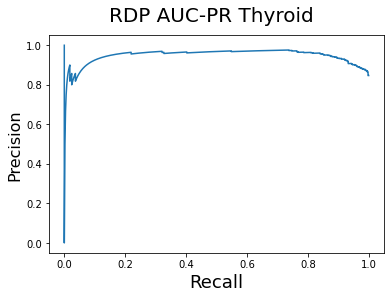

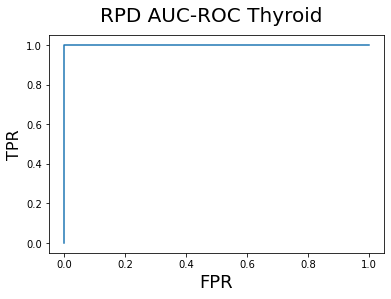

tree id: 21 tic time.
tic_datetime: 2021-12-10 17:22:53.648151
tic_datetime.strftime: 2021-12-10 17:22:53.648151
tic_walltime: 1639156973.6494749
tic_cpu: 3935.351865

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 21 tic time.
tic_datetime: 2021-12-10 17:22:54.766822
tic_datetime.strftime: 2021-12-10 17:22:54.766822
tic_walltime: 1639156974.7676432
tic_cpu: 3936.470773



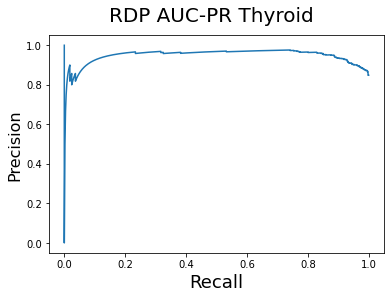

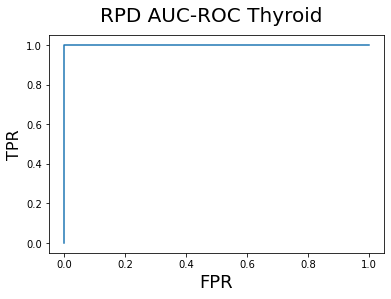

tree id: 22 tic time.
tic_datetime: 2021-12-10 17:22:55.212033
tic_datetime.strftime: 2021-12-10 17:22:55.212033
tic_walltime: 1639156975.2122076
tic_cpu: 3936.91154

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 22 tic time.
tic_datetime: 2021-12-10 17:22:56.342063
tic_datetime.strftime: 2021-12-10 17:22:56.342063
tic_walltime: 1639156976.3428442
tic_cpu: 3938.031895



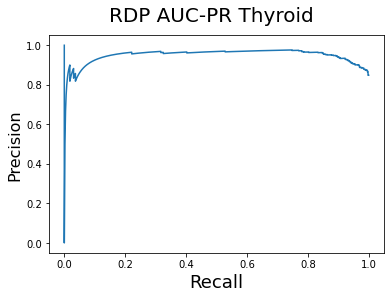

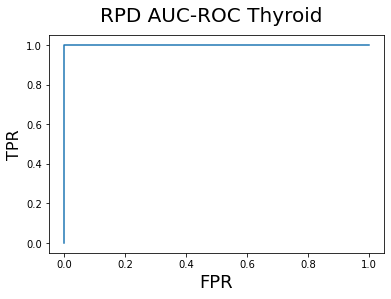

tree id: 23 tic time.
tic_datetime: 2021-12-10 17:22:56.796497
tic_datetime.strftime: 2021-12-10 17:22:56.796497
tic_walltime: 1639156976.796635
tic_cpu: 3938.474474

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 23 tic time.
tic_datetime: 2021-12-10 17:22:57.916097
tic_datetime.strftime: 2021-12-10 17:22:57.916097
tic_walltime: 1639156977.9169269
tic_cpu: 3939.596359



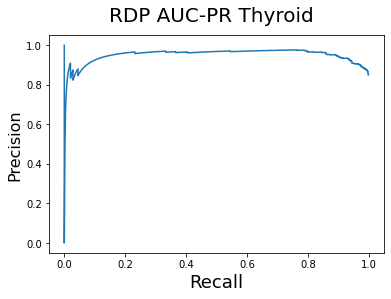

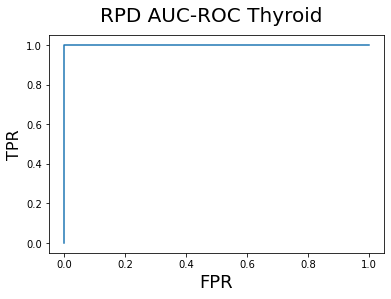

tree id: 24 tic time.
tic_datetime: 2021-12-10 17:22:58.365704
tic_datetime.strftime: 2021-12-10 17:22:58.365704
tic_walltime: 1639156978.3658524
tic_cpu: 3940.043943

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 24 tic time.
tic_datetime: 2021-12-10 17:22:59.486866
tic_datetime.strftime: 2021-12-10 17:22:59.486866
tic_walltime: 1639156979.4870322
tic_cpu: 3941.17135



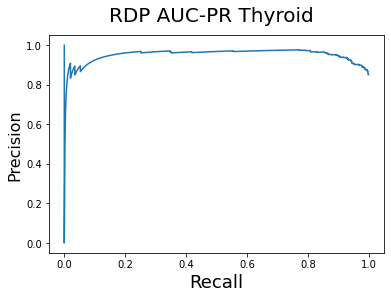

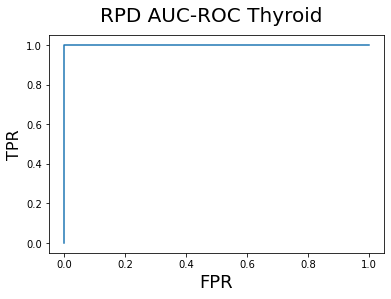

tree id: 25 tic time.
tic_datetime: 2021-12-10 17:23:00.090094
tic_datetime.strftime: 2021-12-10 17:23:00.090094
tic_walltime: 1639156980.0902436
tic_cpu: 3941.780561

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 25 tic time.
tic_datetime: 2021-12-10 17:23:01.201191
tic_datetime.strftime: 2021-12-10 17:23:01.201191
tic_walltime: 1639156981.20137
tic_cpu: 3942.898649



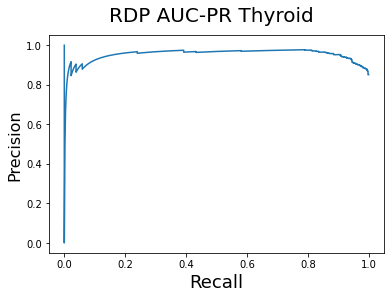

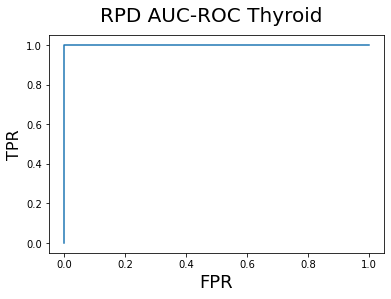

tree id: 26 tic time.
tic_datetime: 2021-12-10 17:23:01.663541
tic_datetime.strftime: 2021-12-10 17:23:01.663541
tic_walltime: 1639156981.6636906
tic_cpu: 3943.358431

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 26 tic time.
tic_datetime: 2021-12-10 17:23:02.797223
tic_datetime.strftime: 2021-12-10 17:23:02.797223
tic_walltime: 1639156982.7974463
tic_cpu: 3944.496306



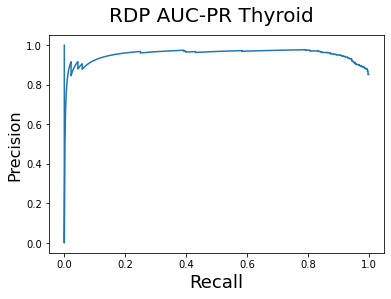

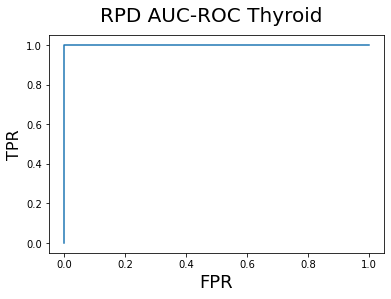

tree id: 27 tic time.
tic_datetime: 2021-12-10 17:23:03.252057
tic_datetime.strftime: 2021-12-10 17:23:03.252057
tic_walltime: 1639156983.2522094
tic_cpu: 3944.945282

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 27 tic time.
tic_datetime: 2021-12-10 17:23:04.377375
tic_datetime.strftime: 2021-12-10 17:23:04.377375
tic_walltime: 1639156984.3775384
tic_cpu: 3946.070314



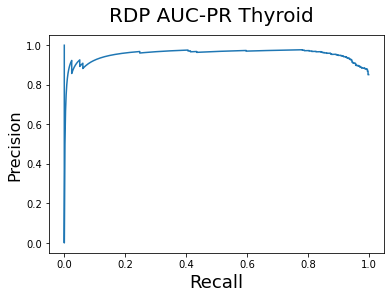

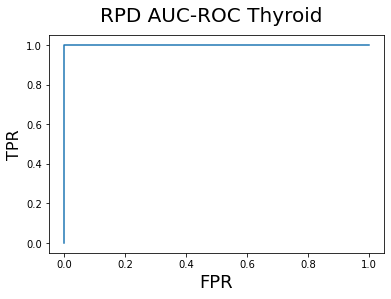

tree id: 28 tic time.
tic_datetime: 2021-12-10 17:23:04.830323
tic_datetime.strftime: 2021-12-10 17:23:04.830323
tic_walltime: 1639156984.8304715
tic_cpu: 3946.525007

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 28 tic time.
tic_datetime: 2021-12-10 17:23:05.950385
tic_datetime.strftime: 2021-12-10 17:23:05.950385
tic_walltime: 1639156985.9505532
tic_cpu: 3947.642998



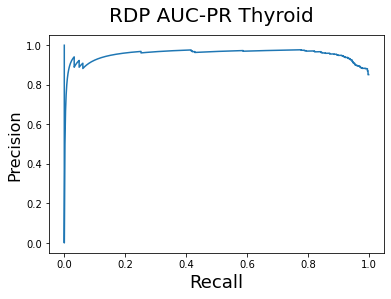

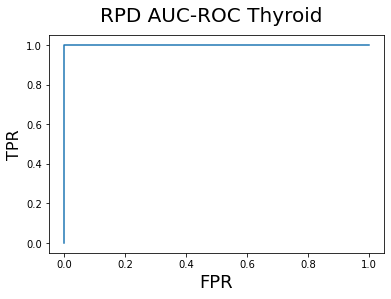

tree id: 29 tic time.
tic_datetime: 2021-12-10 17:23:06.431093
tic_datetime.strftime: 2021-12-10 17:23:06.431093
tic_walltime: 1639156986.4312441
tic_cpu: 3948.129409

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 29 tic time.
tic_datetime: 2021-12-10 17:23:07.550013
tic_datetime.strftime: 2021-12-10 17:23:07.550013
tic_walltime: 1639156987.5501657
tic_cpu: 3949.249952



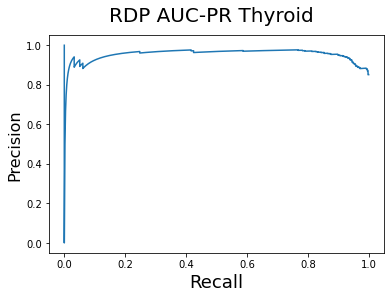

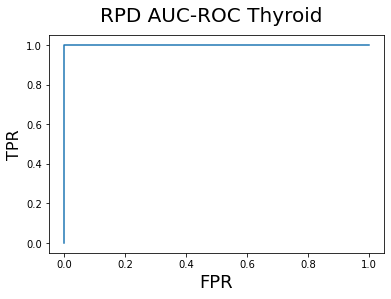

AUC-ROC: 1.0000, AUC-PR: 0.9533
for this run the data being analyzed is  gdrive/MyDrive/data/CreditCardSyntheticCauchy/cc_synthetic_cauchy_mn_scale_1_cov_scale_1.csv
Data shape: (284807, 29)
Init tic time.
tic_datetime: 2021-12-10 17:23:10.875530
tic_datetime.strftime: 2021-12-10 17:23:10.875530
tic_walltime: 1639156990.875692
tic_cpu: 3951.300703

tree id: 0 tic time.
tic_datetime: 2021-12-10 17:23:10.907087
tic_datetime.strftime: 2021-12-10 17:23:10.907087
tic_walltime: 1639156990.9072392
tic_cpu: 3951.336273

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)
tree_id: 1 level: 1
keep_pos.size == 10000
epoch  0 gap_loss: 0.14170997


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Streaming output truncated to the last 5000 lines.
keep_pos.size == 8146
epoch  96 gap_loss: 0.03599328
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  120 gap_loss: 0.034426507
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  144 gap_loss: 0.036066674
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  168 gap_loss: 0.03454643
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  192 gap_loss: 0.032696664
RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)
tree_id: 16 level: 6
keep_pos.size == 7739
epoch  0 gap_loss: 0.07312265
tree_id: 16 level: 6
keep_pos.size == 7739
epoch  24 gap_loss: 0.03232038
tree_id: 16 level: 6
keep_pos.size == 7739

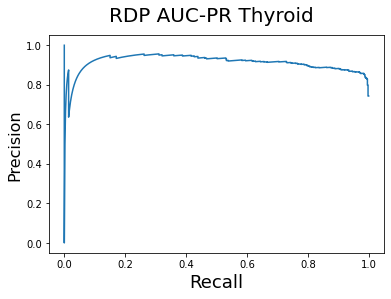

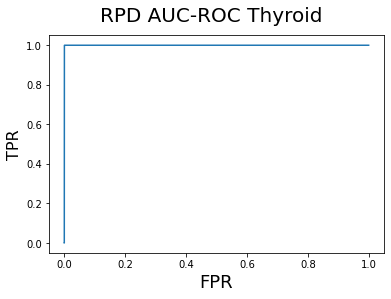

tree id: 1 tic time.
tic_datetime: 2021-12-10 18:29:06.371528
tic_datetime.strftime: 2021-12-10 18:29:06.371528
tic_walltime: 1639160946.371671
tic_cpu: 7908.191519

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 1 tic time.
tic_datetime: 2021-12-10 18:29:07.483919
tic_datetime.strftime: 2021-12-10 18:29:07.483919
tic_walltime: 1639160947.484751
tic_cpu: 7909.315312



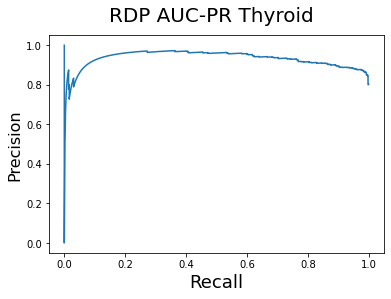

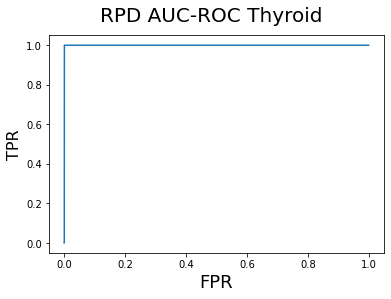

tree id: 2 tic time.
tic_datetime: 2021-12-10 18:29:07.934462
tic_datetime.strftime: 2021-12-10 18:29:07.934462
tic_walltime: 1639160947.9357631
tic_cpu: 7909.763063

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 2 tic time.
tic_datetime: 2021-12-10 18:29:09.047720
tic_datetime.strftime: 2021-12-10 18:29:09.047720
tic_walltime: 1639160949.0485578
tic_cpu: 7910.871119



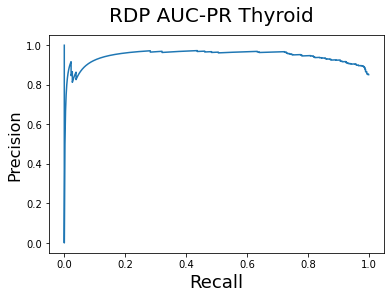

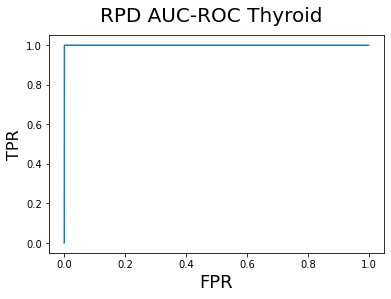

tree id: 3 tic time.
tic_datetime: 2021-12-10 18:29:09.518649
tic_datetime.strftime: 2021-12-10 18:29:09.518649
tic_walltime: 1639160949.5187728
tic_cpu: 7911.334557

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 3 tic time.
tic_datetime: 2021-12-10 18:29:10.625289
tic_datetime.strftime: 2021-12-10 18:29:10.625289
tic_walltime: 1639160950.62607
tic_cpu: 7912.44211



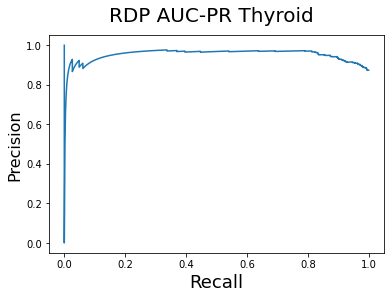

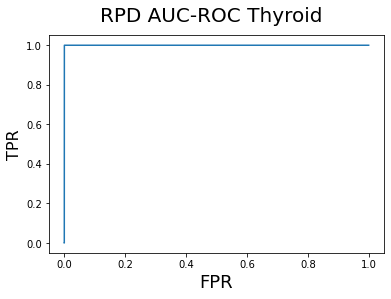

tree id: 4 tic time.
tic_datetime: 2021-12-10 18:29:11.080097
tic_datetime.strftime: 2021-12-10 18:29:11.080097
tic_walltime: 1639160951.0817368
tic_cpu: 7912.895143

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 4 tic time.
tic_datetime: 2021-12-10 18:29:12.205099
tic_datetime.strftime: 2021-12-10 18:29:12.205099
tic_walltime: 1639160952.205277
tic_cpu: 7914.000825



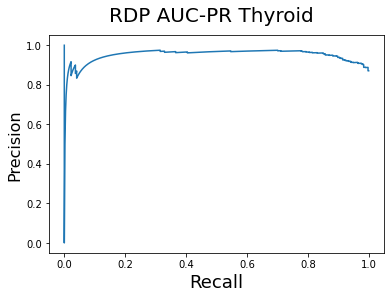

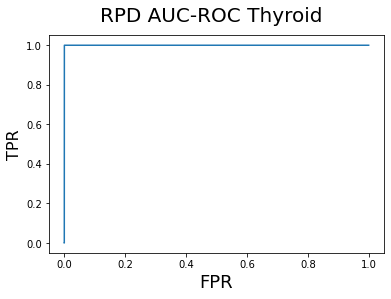

tree id: 5 tic time.
tic_datetime: 2021-12-10 18:29:12.664356
tic_datetime.strftime: 2021-12-10 18:29:12.664356
tic_walltime: 1639160952.6645002
tic_cpu: 7914.45303

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 5 tic time.
tic_datetime: 2021-12-10 18:29:13.769044
tic_datetime.strftime: 2021-12-10 18:29:13.769044
tic_walltime: 1639160953.7692072
tic_cpu: 7915.55917



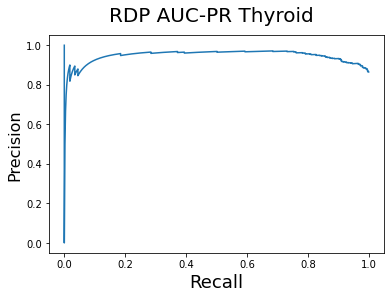

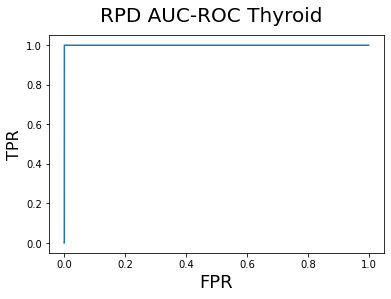

tree id: 6 tic time.
tic_datetime: 2021-12-10 18:29:14.386984
tic_datetime.strftime: 2021-12-10 18:29:14.386984
tic_walltime: 1639160954.388488
tic_cpu: 7916.183018

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 6 tic time.
tic_datetime: 2021-12-10 18:29:15.504862
tic_datetime.strftime: 2021-12-10 18:29:15.504862
tic_walltime: 1639160955.5056386
tic_cpu: 7917.295682



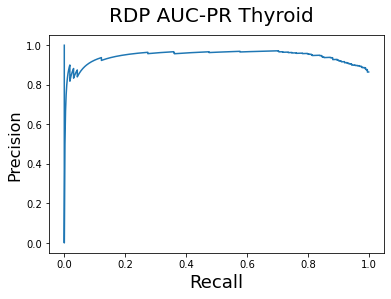

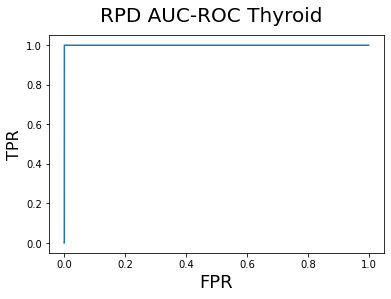

tree id: 7 tic time.
tic_datetime: 2021-12-10 18:29:15.950670
tic_datetime.strftime: 2021-12-10 18:29:15.950670
tic_walltime: 1639160955.9522247
tic_cpu: 7917.741616

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 7 tic time.
tic_datetime: 2021-12-10 18:29:17.074685
tic_datetime.strftime: 2021-12-10 18:29:17.074685
tic_walltime: 1639160957.0748463
tic_cpu: 7918.858977



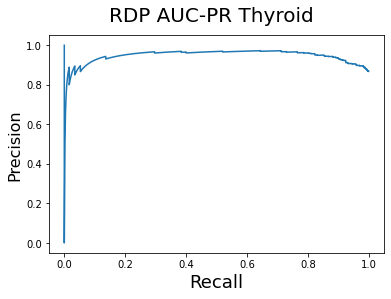

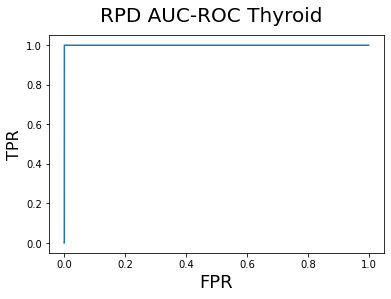

tree id: 8 tic time.
tic_datetime: 2021-12-10 18:29:17.537656
tic_datetime.strftime: 2021-12-10 18:29:17.537656
tic_walltime: 1639160957.5377738
tic_cpu: 7919.322518

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 8 tic time.
tic_datetime: 2021-12-10 18:29:18.651225
tic_datetime.strftime: 2021-12-10 18:29:18.651225
tic_walltime: 1639160958.6520412
tic_cpu: 7920.438048



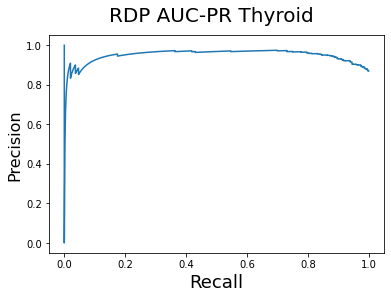

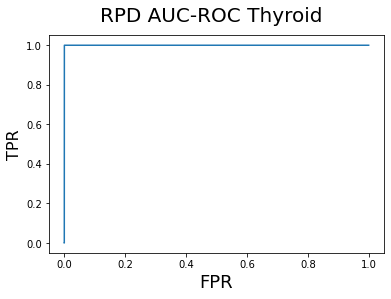

tree id: 9 tic time.
tic_datetime: 2021-12-10 18:29:19.126588
tic_datetime.strftime: 2021-12-10 18:29:19.126588
tic_walltime: 1639160959.128196
tic_cpu: 7920.908904

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 9 tic time.
tic_datetime: 2021-12-10 18:29:20.226192
tic_datetime.strftime: 2021-12-10 18:29:20.226192
tic_walltime: 1639160960.2270124
tic_cpu: 7922.005652



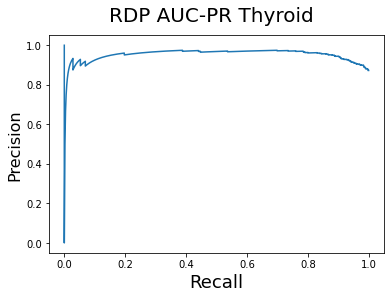

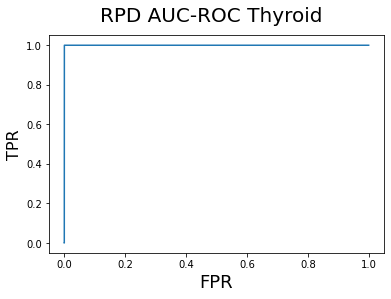

tree id: 10 tic time.
tic_datetime: 2021-12-10 18:29:20.683412
tic_datetime.strftime: 2021-12-10 18:29:20.683412
tic_walltime: 1639160960.6849885
tic_cpu: 7922.462635

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 10 tic time.
tic_datetime: 2021-12-10 18:29:21.791736
tic_datetime.strftime: 2021-12-10 18:29:21.791736
tic_walltime: 1639160961.792557
tic_cpu: 7923.569884



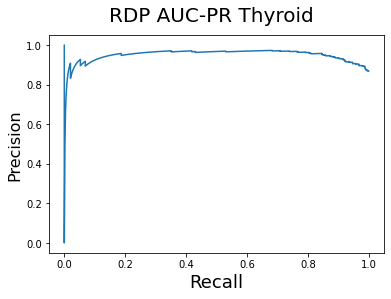

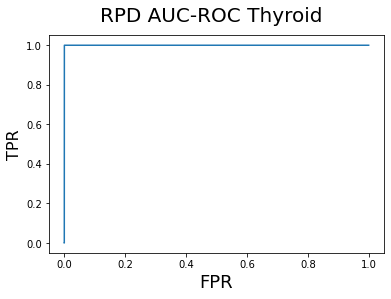

tree id: 11 tic time.
tic_datetime: 2021-12-10 18:29:22.245541
tic_datetime.strftime: 2021-12-10 18:29:22.245541
tic_walltime: 1639160962.2469513
tic_cpu: 7924.016521

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 11 tic time.
tic_datetime: 2021-12-10 18:29:23.351567
tic_datetime.strftime: 2021-12-10 18:29:23.351567
tic_walltime: 1639160963.3517537
tic_cpu: 7925.107385



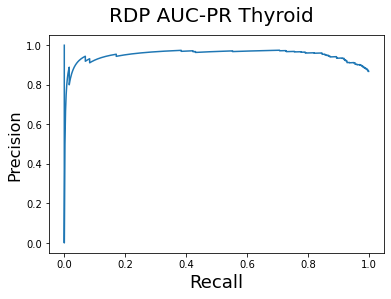

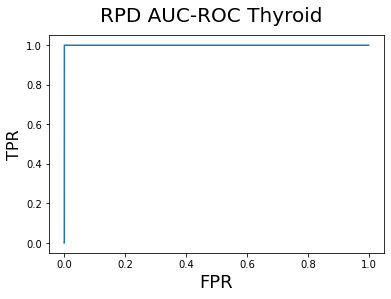

tree id: 12 tic time.
tic_datetime: 2021-12-10 18:29:23.806865
tic_datetime.strftime: 2021-12-10 18:29:23.806865
tic_walltime: 1639160963.8070128
tic_cpu: 7925.5701

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 12 tic time.
tic_datetime: 2021-12-10 18:29:24.918768
tic_datetime.strftime: 2021-12-10 18:29:24.918768
tic_walltime: 1639160964.9189289
tic_cpu: 7926.687594



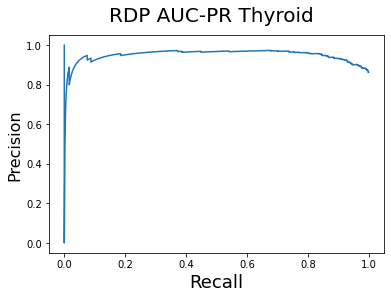

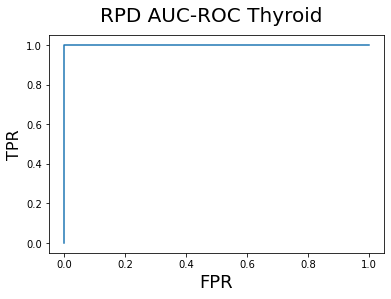

tree id: 13 tic time.
tic_datetime: 2021-12-10 18:29:25.415836
tic_datetime.strftime: 2021-12-10 18:29:25.415836
tic_walltime: 1639160965.4159846
tic_cpu: 7927.201765

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 13 tic time.
tic_datetime: 2021-12-10 18:29:26.542660
tic_datetime.strftime: 2021-12-10 18:29:26.542660
tic_walltime: 1639160966.5434737
tic_cpu: 7928.332137



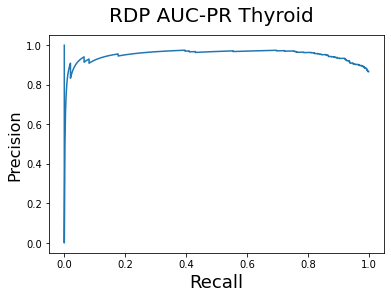

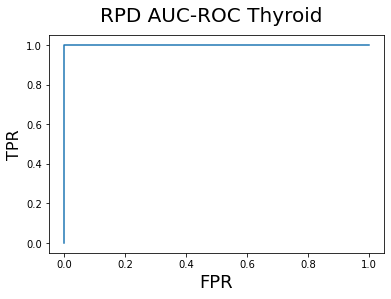

tree id: 14 tic time.
tic_datetime: 2021-12-10 18:29:26.989630
tic_datetime.strftime: 2021-12-10 18:29:26.989630
tic_walltime: 1639160966.9897704
tic_cpu: 7928.774338

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 14 tic time.
tic_datetime: 2021-12-10 18:29:28.124158
tic_datetime.strftime: 2021-12-10 18:29:28.124158
tic_walltime: 1639160968.1249378
tic_cpu: 7929.902637



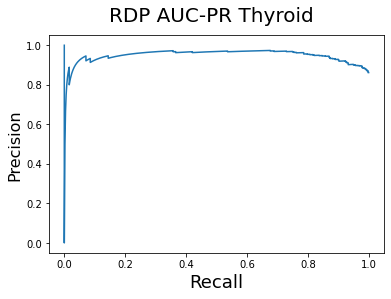

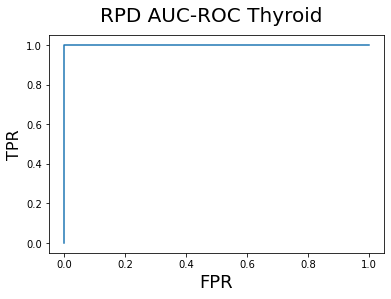

tree id: 15 tic time.
tic_datetime: 2021-12-10 18:29:28.581815
tic_datetime.strftime: 2021-12-10 18:29:28.581815
tic_walltime: 1639160968.581934
tic_cpu: 7930.352717

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 15 tic time.
tic_datetime: 2021-12-10 18:29:29.707950
tic_datetime.strftime: 2021-12-10 18:29:29.707950
tic_walltime: 1639160969.7087934
tic_cpu: 7931.47426



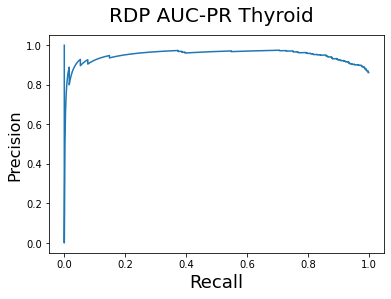

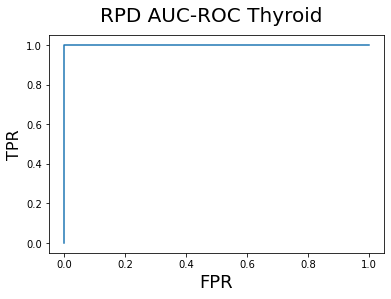

tree id: 16 tic time.
tic_datetime: 2021-12-10 18:29:30.292202
tic_datetime.strftime: 2021-12-10 18:29:30.292202
tic_walltime: 1639160970.2937195
tic_cpu: 7932.064858

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 16 tic time.
tic_datetime: 2021-12-10 18:29:31.412658
tic_datetime.strftime: 2021-12-10 18:29:31.412658
tic_walltime: 1639160971.4134696
tic_cpu: 7933.179076



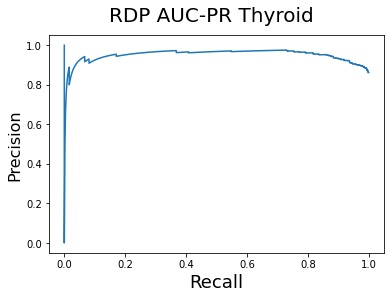

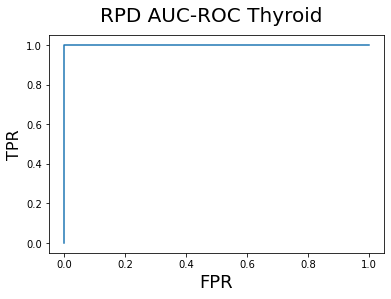

tree id: 17 tic time.
tic_datetime: 2021-12-10 18:29:31.862448
tic_datetime.strftime: 2021-12-10 18:29:31.862448
tic_walltime: 1639160971.8625662
tic_cpu: 7933.623309

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 17 tic time.
tic_datetime: 2021-12-10 18:29:32.982372
tic_datetime.strftime: 2021-12-10 18:29:32.982372
tic_walltime: 1639160972.9828458
tic_cpu: 7934.751908



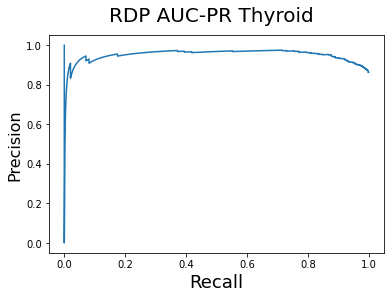

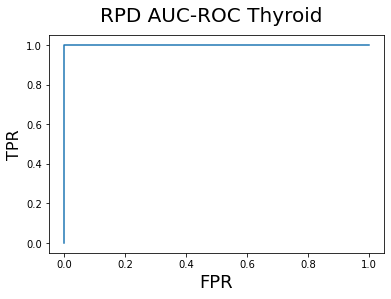

tree id: 18 tic time.
tic_datetime: 2021-12-10 18:29:33.449205
tic_datetime.strftime: 2021-12-10 18:29:33.449205
tic_walltime: 1639160973.449583
tic_cpu: 7935.212231

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 18 tic time.
tic_datetime: 2021-12-10 18:29:34.563977
tic_datetime.strftime: 2021-12-10 18:29:34.563977
tic_walltime: 1639160974.565055
tic_cpu: 7936.324068



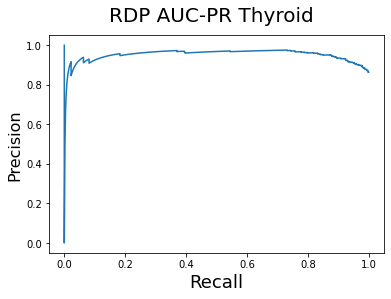

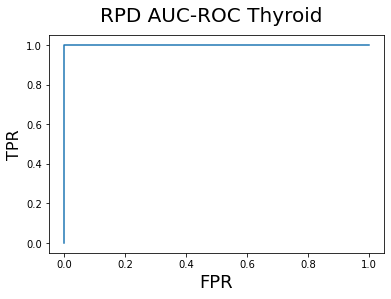

tree id: 19 tic time.
tic_datetime: 2021-12-10 18:29:35.015469
tic_datetime.strftime: 2021-12-10 18:29:35.015469
tic_walltime: 1639160975.0170236
tic_cpu: 7936.772959

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 19 tic time.
tic_datetime: 2021-12-10 18:29:36.148242
tic_datetime.strftime: 2021-12-10 18:29:36.148242
tic_walltime: 1639160976.1484401
tic_cpu: 7937.899955



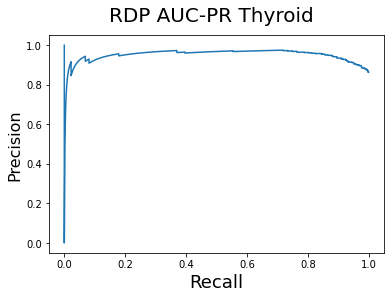

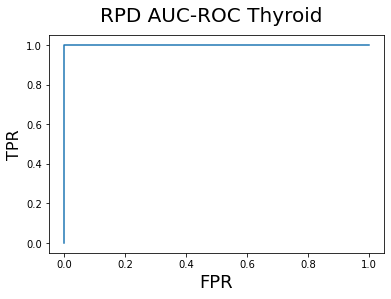

tree id: 20 tic time.
tic_datetime: 2021-12-10 18:29:36.610484
tic_datetime.strftime: 2021-12-10 18:29:36.610484
tic_walltime: 1639160976.611729
tic_cpu: 7938.35758

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 20 tic time.
tic_datetime: 2021-12-10 18:29:37.733027
tic_datetime.strftime: 2021-12-10 18:29:37.733027
tic_walltime: 1639160977.7338548
tic_cpu: 7939.482741



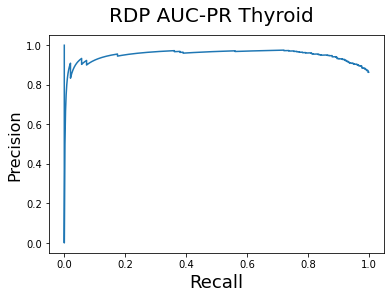

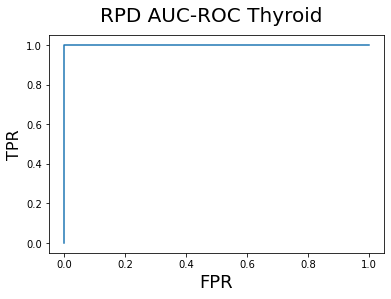

tree id: 21 tic time.
tic_datetime: 2021-12-10 18:29:38.186887
tic_datetime.strftime: 2021-12-10 18:29:38.186887
tic_walltime: 1639160978.1870434
tic_cpu: 7939.939367

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 21 tic time.
tic_datetime: 2021-12-10 18:29:39.297962
tic_datetime.strftime: 2021-12-10 18:29:39.297962
tic_walltime: 1639160979.2981288
tic_cpu: 7941.058465



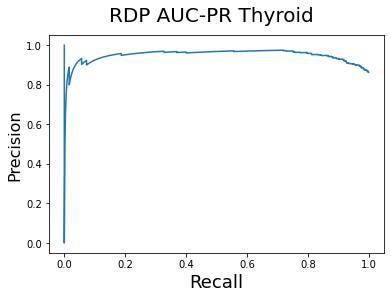

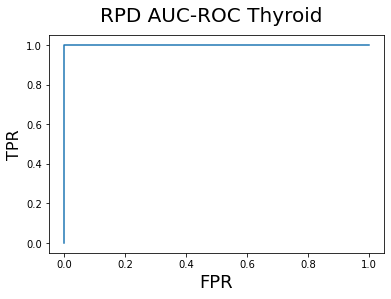

tree id: 22 tic time.
tic_datetime: 2021-12-10 18:29:39.758603
tic_datetime.strftime: 2021-12-10 18:29:39.758603
tic_walltime: 1639160979.7587214
tic_cpu: 7941.514843

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 22 tic time.
tic_datetime: 2021-12-10 18:29:40.870128
tic_datetime.strftime: 2021-12-10 18:29:40.870128
tic_walltime: 1639160980.870937
tic_cpu: 7942.629377



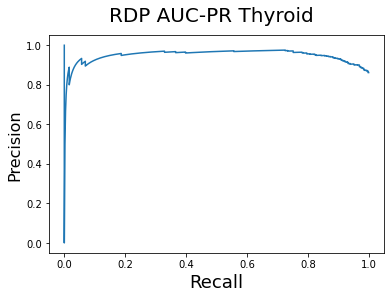

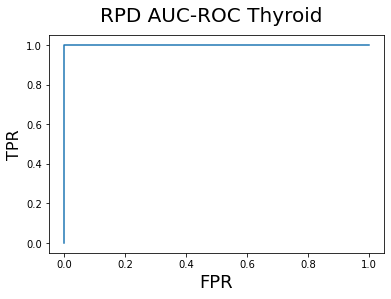

tree id: 23 tic time.
tic_datetime: 2021-12-10 18:29:41.340441
tic_datetime.strftime: 2021-12-10 18:29:41.340441
tic_walltime: 1639160981.340578
tic_cpu: 7943.080458

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 23 tic time.
tic_datetime: 2021-12-10 18:29:42.457852
tic_datetime.strftime: 2021-12-10 18:29:42.457852
tic_walltime: 1639160982.4580142
tic_cpu: 7944.202594



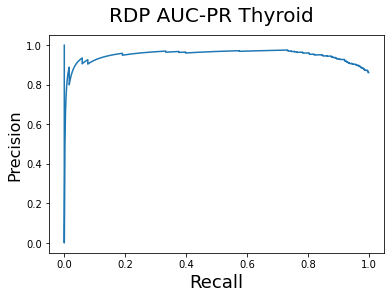

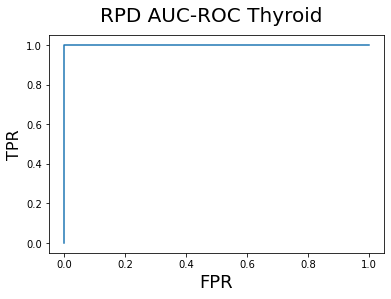

tree id: 24 tic time.
tic_datetime: 2021-12-10 18:29:42.921571
tic_datetime.strftime: 2021-12-10 18:29:42.921571
tic_walltime: 1639160982.922859
tic_cpu: 7944.667776

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 24 tic time.
tic_datetime: 2021-12-10 18:29:44.037026
tic_datetime.strftime: 2021-12-10 18:29:44.037026
tic_walltime: 1639160984.0378432
tic_cpu: 7945.783198



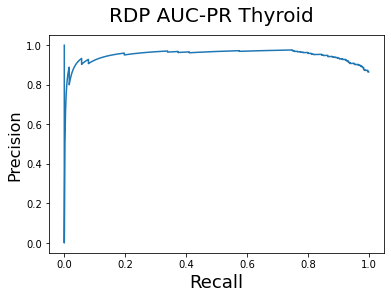

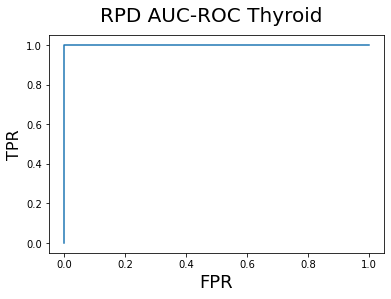

tree id: 25 tic time.
tic_datetime: 2021-12-10 18:29:44.490678
tic_datetime.strftime: 2021-12-10 18:29:44.490678
tic_walltime: 1639160984.4920337
tic_cpu: 7946.241365

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 25 tic time.
tic_datetime: 2021-12-10 18:29:45.610349
tic_datetime.strftime: 2021-12-10 18:29:45.610349
tic_walltime: 1639160985.6105444
tic_cpu: 7947.359613



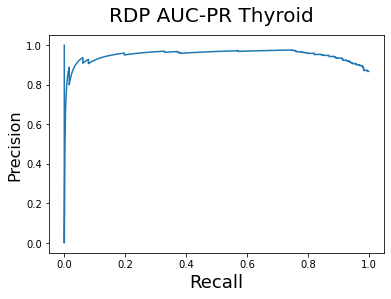

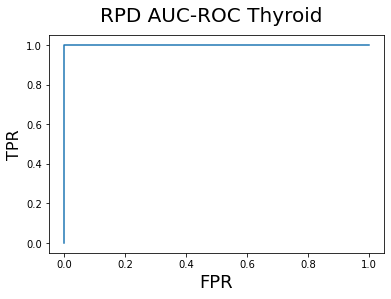

tree id: 26 tic time.
tic_datetime: 2021-12-10 18:29:46.073826
tic_datetime.strftime: 2021-12-10 18:29:46.073826
tic_walltime: 1639160986.0739675
tic_cpu: 7947.82988

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 26 tic time.
tic_datetime: 2021-12-10 18:29:47.207902
tic_datetime.strftime: 2021-12-10 18:29:47.207902
tic_walltime: 1639160987.208059
tic_cpu: 7948.96735



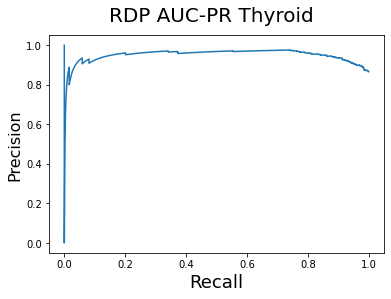

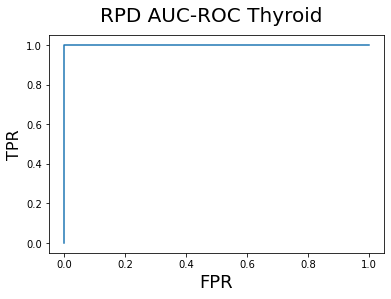

tree id: 27 tic time.
tic_datetime: 2021-12-10 18:29:47.816334
tic_datetime.strftime: 2021-12-10 18:29:47.816334
tic_walltime: 1639160987.8164515
tic_cpu: 7949.574787

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 27 tic time.
tic_datetime: 2021-12-10 18:29:48.923922
tic_datetime.strftime: 2021-12-10 18:29:48.923922
tic_walltime: 1639160988.9247572
tic_cpu: 7950.682798



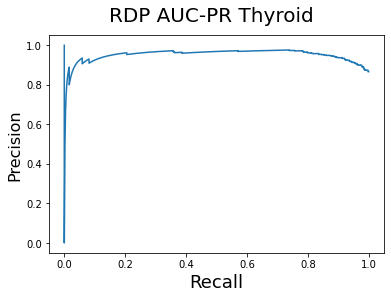

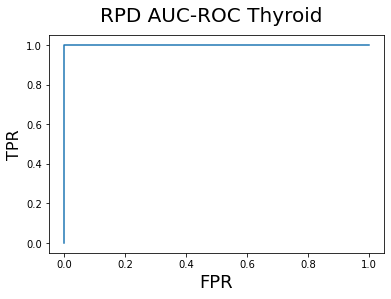

tree id: 28 tic time.
tic_datetime: 2021-12-10 18:29:49.382517
tic_datetime.strftime: 2021-12-10 18:29:49.382517
tic_walltime: 1639160989.3837843
tic_cpu: 7951.140899

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 28 tic time.
tic_datetime: 2021-12-10 18:29:50.502167
tic_datetime.strftime: 2021-12-10 18:29:50.502167
tic_walltime: 1639160990.5023372
tic_cpu: 7952.257047



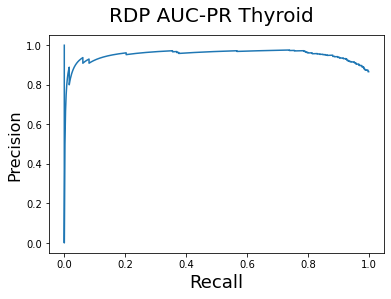

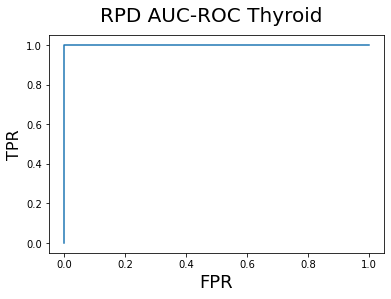

tree id: 29 tic time.
tic_datetime: 2021-12-10 18:29:50.966248
tic_datetime.strftime: 2021-12-10 18:29:50.966248
tic_walltime: 1639160990.9675791
tic_cpu: 7952.722277

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 29 tic time.
tic_datetime: 2021-12-10 18:29:52.093968
tic_datetime.strftime: 2021-12-10 18:29:52.093968
tic_walltime: 1639160992.0947523
tic_cpu: 7953.849881



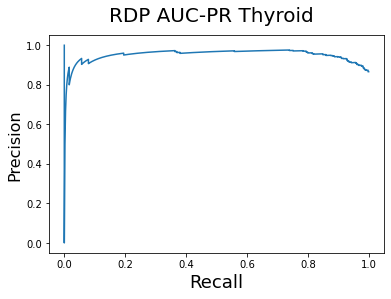

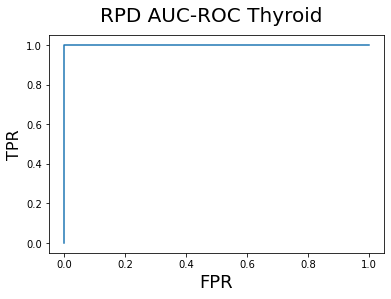

AUC-ROC: 1.0000, AUC-PR: 0.9502
for this run the data being analyzed is  gdrive/MyDrive/data/CreditCardSyntheticCauchy/cc_synthetic_cauchy_mn_scale_1.1_cov_scale_1.csv
Data shape: (284807, 29)
Init tic time.
tic_datetime: 2021-12-10 18:29:55.380228
tic_datetime.strftime: 2021-12-10 18:29:55.380228
tic_walltime: 1639160995.3832629
tic_cpu: 7955.71446

tree id: 0 tic time.
tic_datetime: 2021-12-10 18:29:55.411832
tic_datetime.strftime: 2021-12-10 18:29:55.411832
tic_walltime: 1639160995.411984
tic_cpu: 7955.744022

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)
tree_id: 1 level: 1
keep_pos.size == 10000
epoch  0 gap_loss: 0.07237592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Streaming output truncated to the last 5000 lines.
keep_pos.size == 8146
epoch  96 gap_loss: 0.026791679
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  120 gap_loss: 0.026952466
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  144 gap_loss: 0.026039636
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  168 gap_loss: 0.02585685
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  192 gap_loss: 0.027125558
RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)
tree_id: 16 level: 6
keep_pos.size == 7739
epoch  0 gap_loss: 0.07977723
tree_id: 16 level: 6
keep_pos.size == 7739
epoch  24 gap_loss: 0.016328117
tree_id: 16 level: 6
keep_pos.size == 77

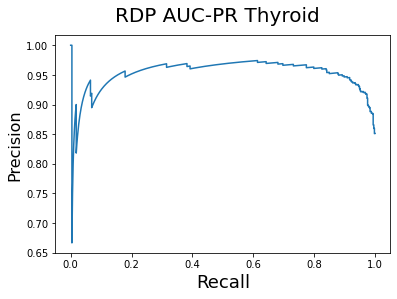

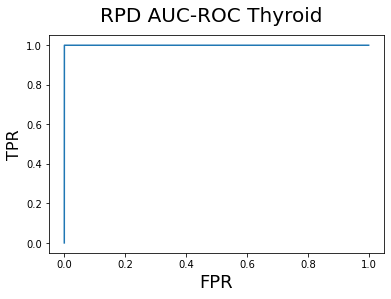

tree id: 1 tic time.
tic_datetime: 2021-12-10 19:35:39.967446
tic_datetime.strftime: 2021-12-10 19:35:39.967446
tic_walltime: 1639164939.9675646
tic_cpu: 11902.52169

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 1 tic time.
tic_datetime: 2021-12-10 19:35:41.087319
tic_datetime.strftime: 2021-12-10 19:35:41.087319
tic_walltime: 1639164941.0881145
tic_cpu: 11903.646439



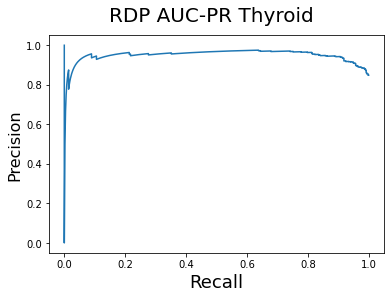

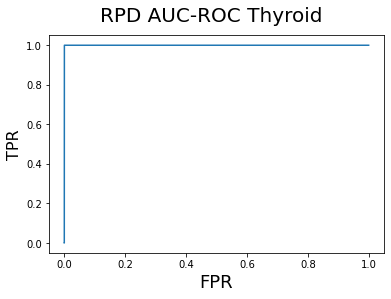

tree id: 2 tic time.
tic_datetime: 2021-12-10 19:35:41.570091
tic_datetime.strftime: 2021-12-10 19:35:41.570091
tic_walltime: 1639164941.5704727
tic_cpu: 11904.125536

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 2 tic time.
tic_datetime: 2021-12-10 19:35:42.706301
tic_datetime.strftime: 2021-12-10 19:35:42.706301
tic_walltime: 1639164942.7064486
tic_cpu: 11905.264752



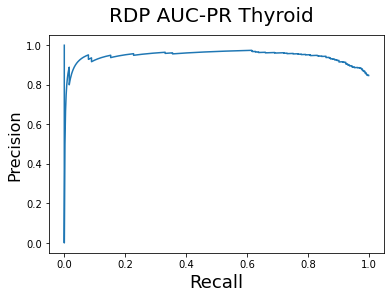

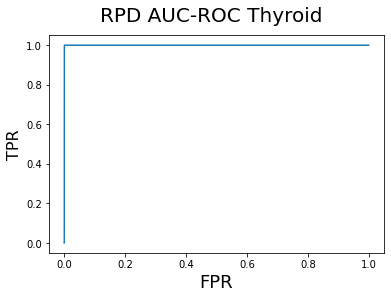

tree id: 3 tic time.
tic_datetime: 2021-12-10 19:35:43.163157
tic_datetime.strftime: 2021-12-10 19:35:43.163157
tic_walltime: 1639164943.1633782
tic_cpu: 11905.724874

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 3 tic time.
tic_datetime: 2021-12-10 19:35:44.283154
tic_datetime.strftime: 2021-12-10 19:35:44.283154
tic_walltime: 1639164944.2842903
tic_cpu: 11906.845124



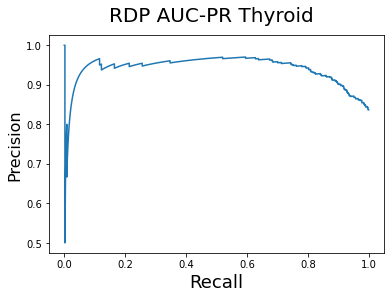

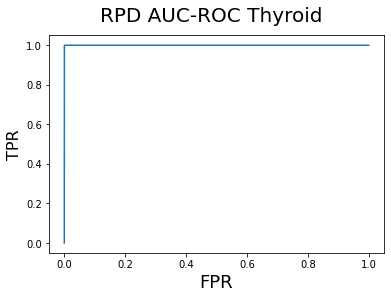

tree id: 4 tic time.
tic_datetime: 2021-12-10 19:35:44.750611
tic_datetime.strftime: 2021-12-10 19:35:44.750611
tic_walltime: 1639164944.750732
tic_cpu: 11907.307873

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 4 tic time.
tic_datetime: 2021-12-10 19:35:45.882090
tic_datetime.strftime: 2021-12-10 19:35:45.882090
tic_walltime: 1639164945.8822381
tic_cpu: 11908.437866



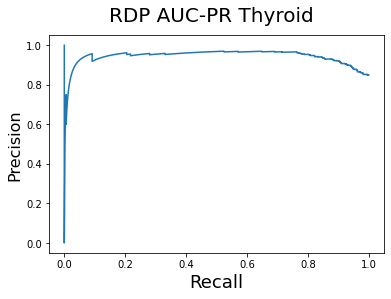

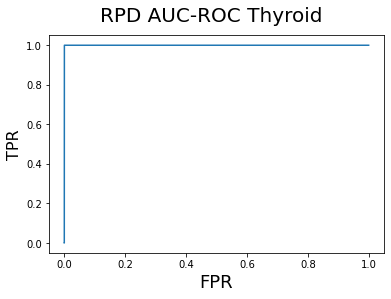

tree id: 5 tic time.
tic_datetime: 2021-12-10 19:35:46.355627
tic_datetime.strftime: 2021-12-10 19:35:46.355627
tic_walltime: 1639164946.3557677
tic_cpu: 11908.91408

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 5 tic time.
tic_datetime: 2021-12-10 19:35:47.493248
tic_datetime.strftime: 2021-12-10 19:35:47.493248
tic_walltime: 1639164947.494018
tic_cpu: 11910.04183



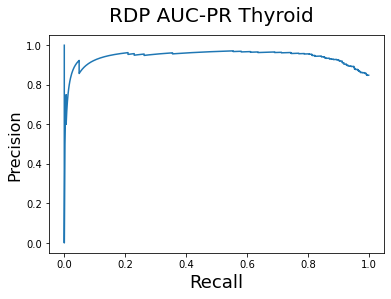

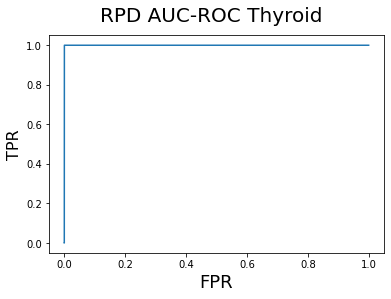

tree id: 6 tic time.
tic_datetime: 2021-12-10 19:35:47.947917
tic_datetime.strftime: 2021-12-10 19:35:47.947917
tic_walltime: 1639164947.9480608
tic_cpu: 11910.495051

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 6 tic time.
tic_datetime: 2021-12-10 19:35:49.064993
tic_datetime.strftime: 2021-12-10 19:35:49.064993
tic_walltime: 1639164949.0651572
tic_cpu: 11911.60849



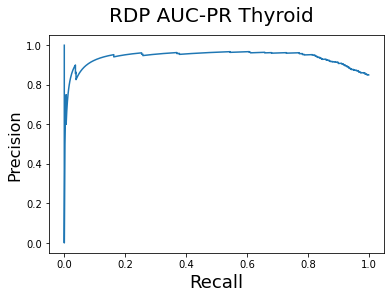

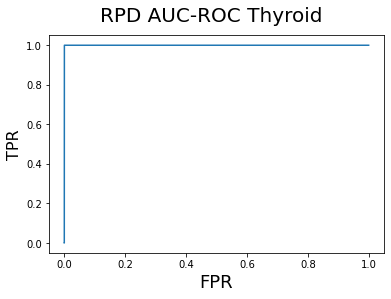

tree id: 7 tic time.
tic_datetime: 2021-12-10 19:35:49.654058
tic_datetime.strftime: 2021-12-10 19:35:49.654058
tic_walltime: 1639164949.6542528
tic_cpu: 11912.196477

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 7 tic time.
tic_datetime: 2021-12-10 19:35:50.774109
tic_datetime.strftime: 2021-12-10 19:35:50.774109
tic_walltime: 1639164950.7742887
tic_cpu: 11913.317144



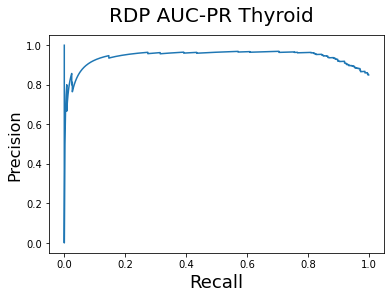

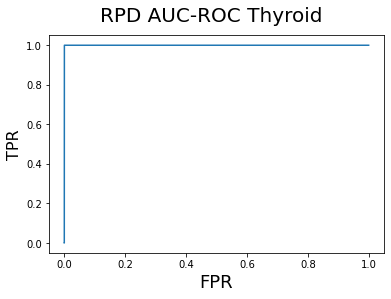

tree id: 8 tic time.
tic_datetime: 2021-12-10 19:35:51.231774
tic_datetime.strftime: 2021-12-10 19:35:51.231774
tic_walltime: 1639164951.231911
tic_cpu: 11913.761757

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 8 tic time.
tic_datetime: 2021-12-10 19:35:52.361983
tic_datetime.strftime: 2021-12-10 19:35:52.361983
tic_walltime: 1639164952.3633404
tic_cpu: 11914.88103



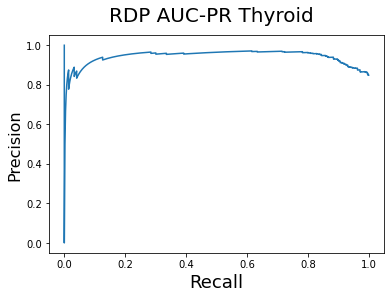

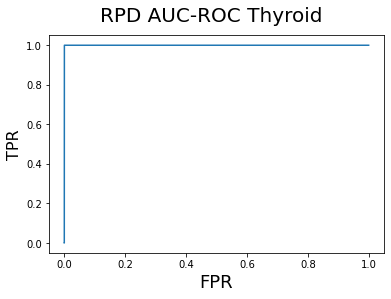

tree id: 9 tic time.
tic_datetime: 2021-12-10 19:35:52.825373
tic_datetime.strftime: 2021-12-10 19:35:52.825373
tic_walltime: 1639164952.8287966
tic_cpu: 11915.342414

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 9 tic time.
tic_datetime: 2021-12-10 19:35:53.959603
tic_datetime.strftime: 2021-12-10 19:35:53.959603
tic_walltime: 1639164953.9597576
tic_cpu: 11916.473566



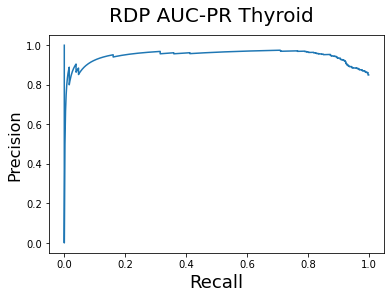

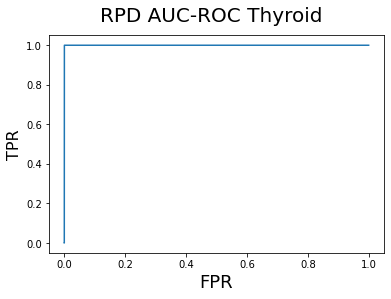

tree id: 10 tic time.
tic_datetime: 2021-12-10 19:35:54.430578
tic_datetime.strftime: 2021-12-10 19:35:54.430578
tic_walltime: 1639164954.4373999
tic_cpu: 11916.930979

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 10 tic time.
tic_datetime: 2021-12-10 19:35:55.562476
tic_datetime.strftime: 2021-12-10 19:35:55.562476
tic_walltime: 1639164955.563243
tic_cpu: 11918.054455



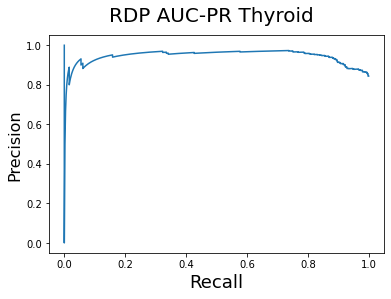

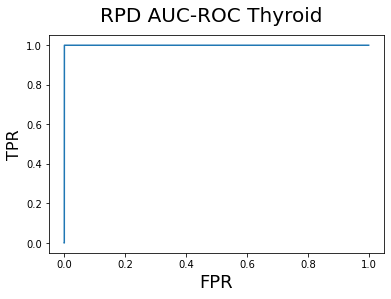

tree id: 11 tic time.
tic_datetime: 2021-12-10 19:35:56.020467
tic_datetime.strftime: 2021-12-10 19:35:56.020467
tic_walltime: 1639164956.021763
tic_cpu: 11918.50931

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 11 tic time.
tic_datetime: 2021-12-10 19:35:57.145052
tic_datetime.strftime: 2021-12-10 19:35:57.145052
tic_walltime: 1639164957.1458604
tic_cpu: 11919.629542



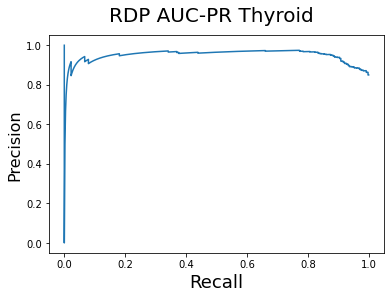

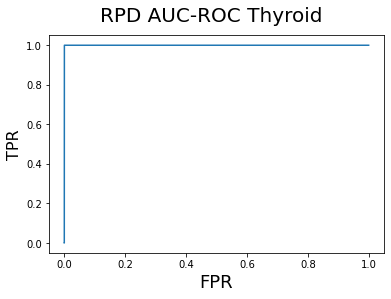

tree id: 12 tic time.
tic_datetime: 2021-12-10 19:35:57.605639
tic_datetime.strftime: 2021-12-10 19:35:57.605639
tic_walltime: 1639164957.6057832
tic_cpu: 11920.089929

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 12 tic time.
tic_datetime: 2021-12-10 19:35:58.732014
tic_datetime.strftime: 2021-12-10 19:35:58.732014
tic_walltime: 1639164958.7321653
tic_cpu: 11921.211938



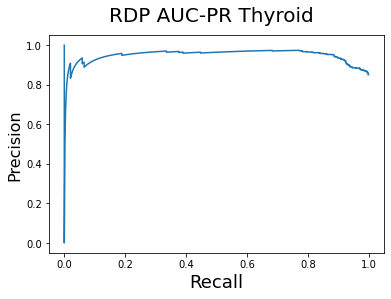

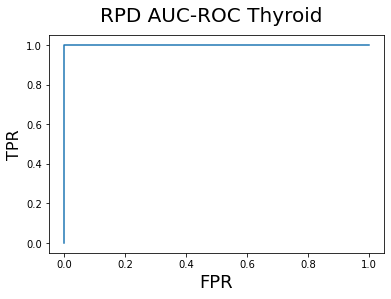

tree id: 13 tic time.
tic_datetime: 2021-12-10 19:35:59.196601
tic_datetime.strftime: 2021-12-10 19:35:59.196601
tic_walltime: 1639164959.1967406
tic_cpu: 11921.678783

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 13 tic time.
tic_datetime: 2021-12-10 19:36:00.331714
tic_datetime.strftime: 2021-12-10 19:36:00.331714
tic_walltime: 1639164960.3325126
tic_cpu: 11922.817322



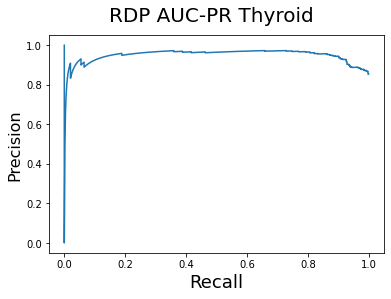

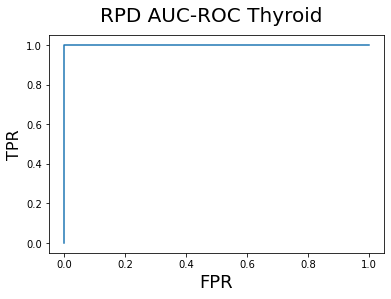

tree id: 14 tic time.
tic_datetime: 2021-12-10 19:36:00.791647
tic_datetime.strftime: 2021-12-10 19:36:00.791647
tic_walltime: 1639164960.7929049
tic_cpu: 11923.273702

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 14 tic time.
tic_datetime: 2021-12-10 19:36:01.920641
tic_datetime.strftime: 2021-12-10 19:36:01.920641
tic_walltime: 1639164961.9208024
tic_cpu: 11924.400544



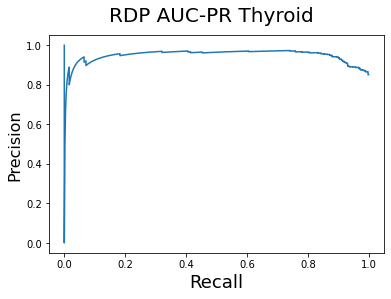

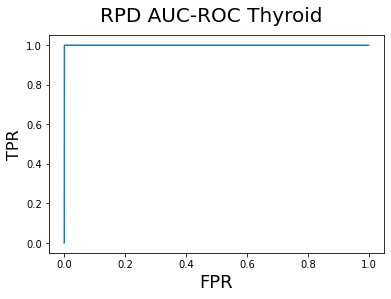

tree id: 15 tic time.
tic_datetime: 2021-12-10 19:36:02.388177
tic_datetime.strftime: 2021-12-10 19:36:02.388177
tic_walltime: 1639164962.3895
tic_cpu: 11924.878544

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 15 tic time.
tic_datetime: 2021-12-10 19:36:03.523880
tic_datetime.strftime: 2021-12-10 19:36:03.523880
tic_walltime: 1639164963.5240588
tic_cpu: 11926.009235



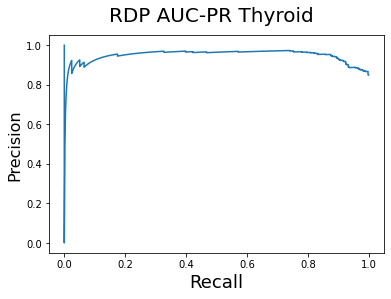

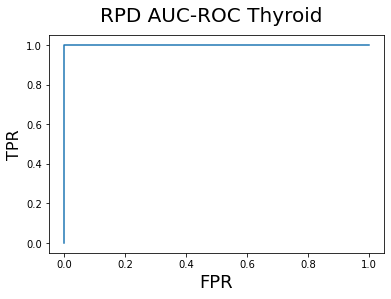

tree id: 16 tic time.
tic_datetime: 2021-12-10 19:36:03.985713
tic_datetime.strftime: 2021-12-10 19:36:03.985713
tic_walltime: 1639164963.9874701
tic_cpu: 11926.461699

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 16 tic time.
tic_datetime: 2021-12-10 19:36:05.118382
tic_datetime.strftime: 2021-12-10 19:36:05.118382
tic_walltime: 1639164965.1185787
tic_cpu: 11927.581401



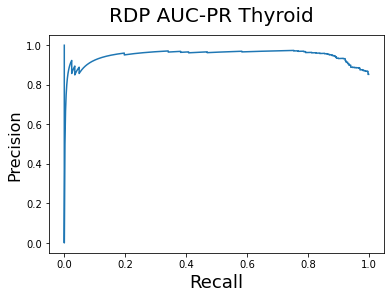

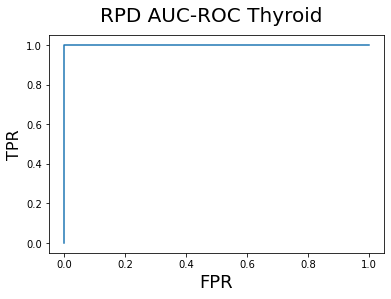

tree id: 17 tic time.
tic_datetime: 2021-12-10 19:36:05.573422
tic_datetime.strftime: 2021-12-10 19:36:05.573422
tic_walltime: 1639164965.5735586
tic_cpu: 11928.032366

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 17 tic time.
tic_datetime: 2021-12-10 19:36:06.701603
tic_datetime.strftime: 2021-12-10 19:36:06.701603
tic_walltime: 1639164966.7017717
tic_cpu: 11929.155945



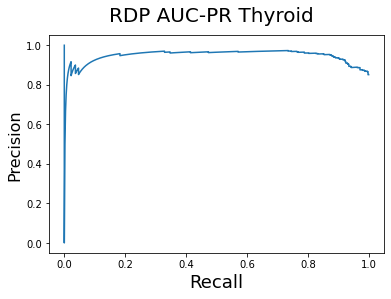

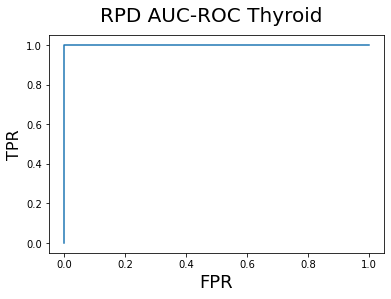

tree id: 18 tic time.
tic_datetime: 2021-12-10 19:36:07.297551
tic_datetime.strftime: 2021-12-10 19:36:07.297551
tic_walltime: 1639164967.297897
tic_cpu: 11929.753603

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 18 tic time.
tic_datetime: 2021-12-10 19:36:08.429592
tic_datetime.strftime: 2021-12-10 19:36:08.429592
tic_walltime: 1639164968.4297364
tic_cpu: 11930.887722



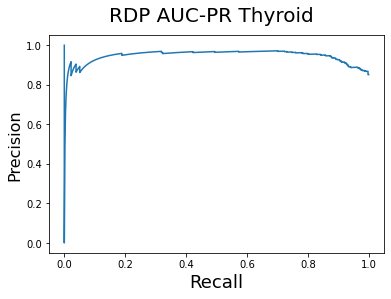

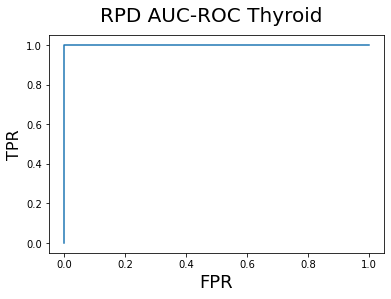

tree id: 19 tic time.
tic_datetime: 2021-12-10 19:36:08.899641
tic_datetime.strftime: 2021-12-10 19:36:08.899641
tic_walltime: 1639164968.9012308
tic_cpu: 11931.353529

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 19 tic time.
tic_datetime: 2021-12-10 19:36:10.030761
tic_datetime.strftime: 2021-12-10 19:36:10.030761
tic_walltime: 1639164970.0313544
tic_cpu: 11932.478828



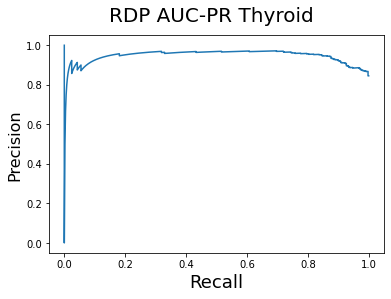

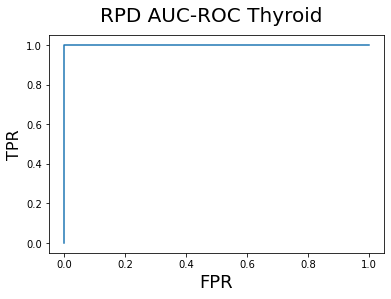

tree id: 20 tic time.
tic_datetime: 2021-12-10 19:36:10.494777
tic_datetime.strftime: 2021-12-10 19:36:10.494777
tic_walltime: 1639164970.4960485
tic_cpu: 11932.94352

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 20 tic time.
tic_datetime: 2021-12-10 19:36:11.623100
tic_datetime.strftime: 2021-12-10 19:36:11.623100
tic_walltime: 1639164971.6232638
tic_cpu: 11934.067081



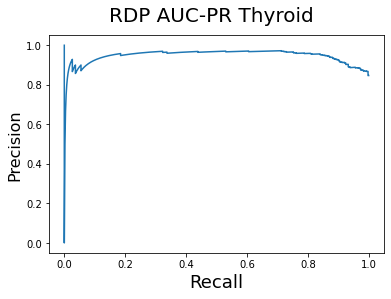

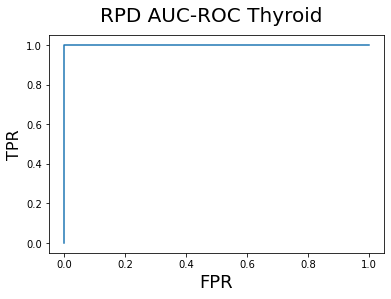

tree id: 21 tic time.
tic_datetime: 2021-12-10 19:36:12.094326
tic_datetime.strftime: 2021-12-10 19:36:12.094326
tic_walltime: 1639164972.095518
tic_cpu: 11934.547551

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 21 tic time.
tic_datetime: 2021-12-10 19:36:13.237660
tic_datetime.strftime: 2021-12-10 19:36:13.237660
tic_walltime: 1639164973.2384722
tic_cpu: 11935.677447



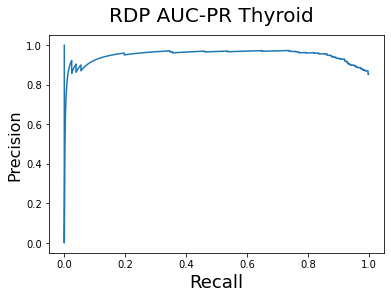

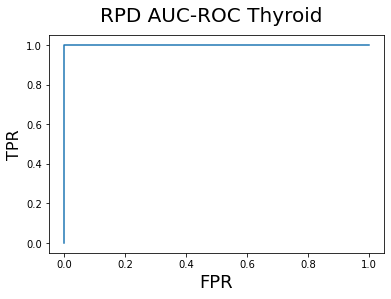

tree id: 22 tic time.
tic_datetime: 2021-12-10 19:36:13.688539
tic_datetime.strftime: 2021-12-10 19:36:13.688539
tic_walltime: 1639164973.7011058
tic_cpu: 11936.128146

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 22 tic time.
tic_datetime: 2021-12-10 19:36:14.826974
tic_datetime.strftime: 2021-12-10 19:36:14.826974
tic_walltime: 1639164974.8277435
tic_cpu: 11937.256463



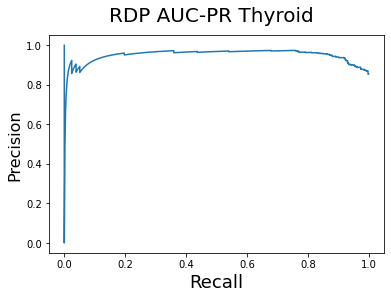

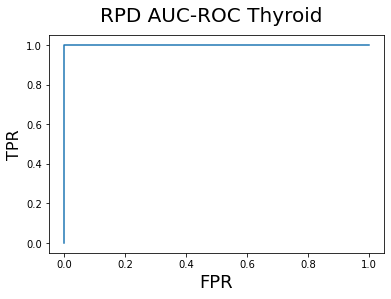

tree id: 23 tic time.
tic_datetime: 2021-12-10 19:36:15.285168
tic_datetime.strftime: 2021-12-10 19:36:15.285168
tic_walltime: 1639164975.2864645
tic_cpu: 11937.717877

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 23 tic time.
tic_datetime: 2021-12-10 19:36:16.411447
tic_datetime.strftime: 2021-12-10 19:36:16.411447
tic_walltime: 1639164976.4123683
tic_cpu: 11938.845471



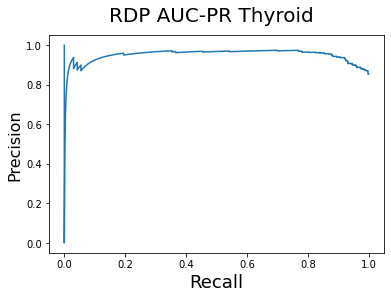

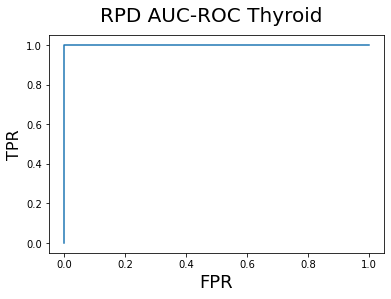

tree id: 24 tic time.
tic_datetime: 2021-12-10 19:36:16.860697
tic_datetime.strftime: 2021-12-10 19:36:16.860697
tic_walltime: 1639164976.8621192
tic_cpu: 11939.298003

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 24 tic time.
tic_datetime: 2021-12-10 19:36:17.988382
tic_datetime.strftime: 2021-12-10 19:36:17.988382
tic_walltime: 1639164977.9885726
tic_cpu: 11940.426198



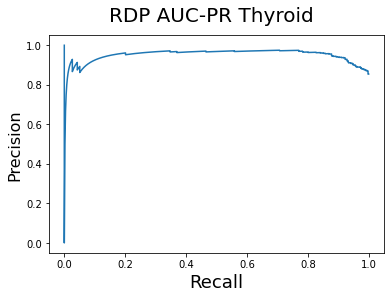

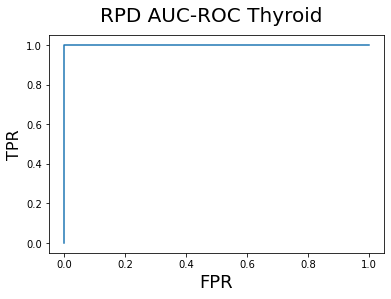

tree id: 25 tic time.
tic_datetime: 2021-12-10 19:36:18.459186
tic_datetime.strftime: 2021-12-10 19:36:18.459186
tic_walltime: 1639164978.459333
tic_cpu: 11940.901614

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 25 tic time.
tic_datetime: 2021-12-10 19:36:19.590756
tic_datetime.strftime: 2021-12-10 19:36:19.590756
tic_walltime: 1639164979.5913463
tic_cpu: 11942.043195



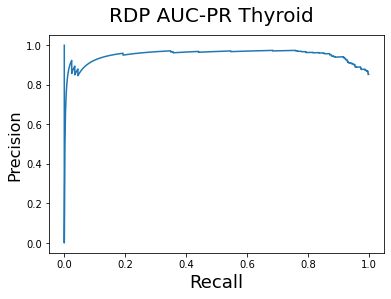

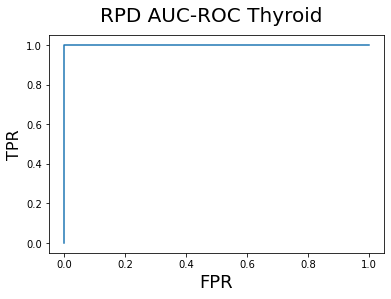

tree id: 26 tic time.
tic_datetime: 2021-12-10 19:36:20.066931
tic_datetime.strftime: 2021-12-10 19:36:20.066931
tic_walltime: 1639164980.0670738
tic_cpu: 11942.534383

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 26 tic time.
tic_datetime: 2021-12-10 19:36:21.200604
tic_datetime.strftime: 2021-12-10 19:36:21.200604
tic_walltime: 1639164981.200995
tic_cpu: 11943.677547



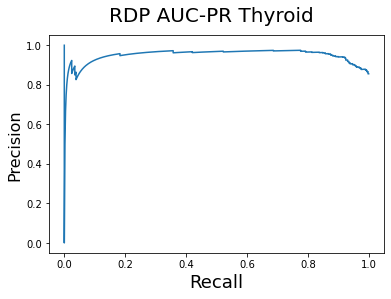

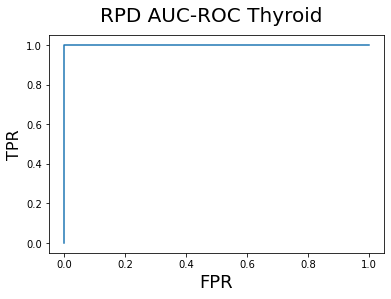

tree id: 27 tic time.
tic_datetime: 2021-12-10 19:36:21.670785
tic_datetime.strftime: 2021-12-10 19:36:21.670785
tic_walltime: 1639164981.672256
tic_cpu: 11944.14561

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 27 tic time.
tic_datetime: 2021-12-10 19:36:22.801860
tic_datetime.strftime: 2021-12-10 19:36:22.801860
tic_walltime: 1639164982.8020182
tic_cpu: 11945.271944



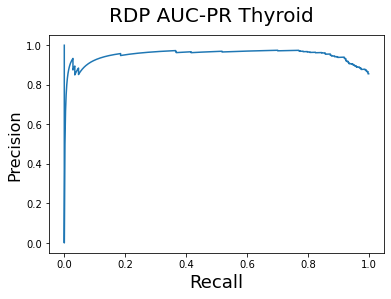

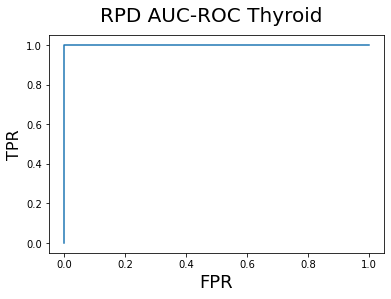

tree id: 28 tic time.
tic_datetime: 2021-12-10 19:36:23.405731
tic_datetime.strftime: 2021-12-10 19:36:23.405731
tic_walltime: 1639164983.405859
tic_cpu: 11945.871841

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 28 tic time.
tic_datetime: 2021-12-10 19:36:24.538324
tic_datetime.strftime: 2021-12-10 19:36:24.538324
tic_walltime: 1639164984.539114
tic_cpu: 11947.003099



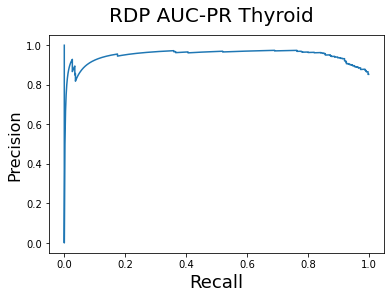

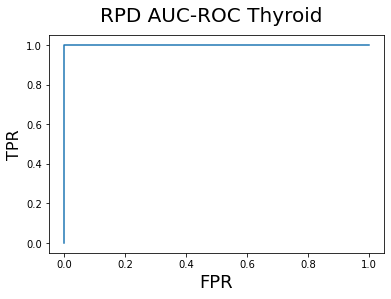

tree id: 29 tic time.
tic_datetime: 2021-12-10 19:36:24.987522
tic_datetime.strftime: 2021-12-10 19:36:24.987522
tic_walltime: 1639164984.9876766
tic_cpu: 11947.44635

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 29 tic time.
tic_datetime: 2021-12-10 19:36:26.125206
tic_datetime.strftime: 2021-12-10 19:36:26.125206
tic_walltime: 1639164986.1253886
tic_cpu: 11948.593017



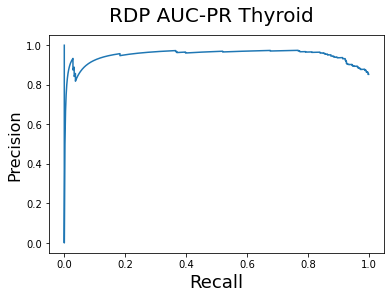

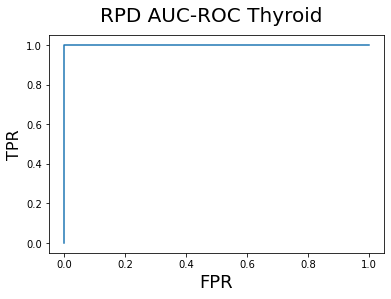

AUC-ROC: 1.0000, AUC-PR: 0.9479
for this run the data being analyzed is  gdrive/MyDrive/data/CreditCardSyntheticCauchy/cc_synthetic_cauchy_mn_scale_1.5_cov_scale_1.csv
Data shape: (284807, 29)
Init tic time.
tic_datetime: 2021-12-10 19:36:29.277654
tic_datetime.strftime: 2021-12-10 19:36:29.277654
tic_walltime: 1639164989.2784667
tic_cpu: 11950.227777

tree id: 0 tic time.
tic_datetime: 2021-12-10 19:36:29.305989
tic_datetime.strftime: 2021-12-10 19:36:29.305989
tic_walltime: 1639164989.306159
tic_cpu: 11950.255186

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)
tree_id: 1 level: 1
keep_pos.size == 10000
epoch  0 gap_loss: 0.19280471


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Streaming output truncated to the last 5000 lines.
keep_pos.size == 8146
epoch  96 gap_loss: 0.04410537
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  120 gap_loss: 0.04646531
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  144 gap_loss: 0.042548645
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  168 gap_loss: 0.041008685
tree_id: 16 level: 5
keep_pos.size == 8146
epoch  192 gap_loss: 0.042088717
RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)
tree_id: 16 level: 6
keep_pos.size == 7739
epoch  0 gap_loss: 0.11146718
tree_id: 16 level: 6
keep_pos.size == 7739
epoch  24 gap_loss: 0.03894587
tree_id: 16 level: 6
keep_pos.size == 7739

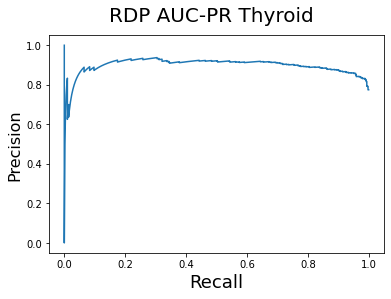

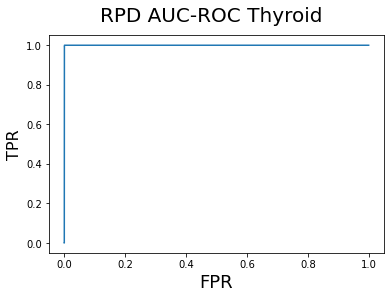

tree id: 1 tic time.
tic_datetime: 2021-12-10 20:40:27.649619
tic_datetime.strftime: 2021-12-10 20:40:27.649619
tic_walltime: 1639168827.6497636
tic_cpu: 15790.559275

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 1 tic time.
tic_datetime: 2021-12-10 20:40:28.802955
tic_datetime.strftime: 2021-12-10 20:40:28.802955
tic_walltime: 1639168828.8031306
tic_cpu: 15791.714459



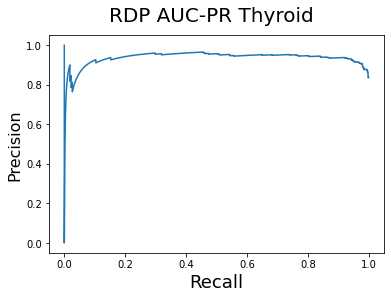

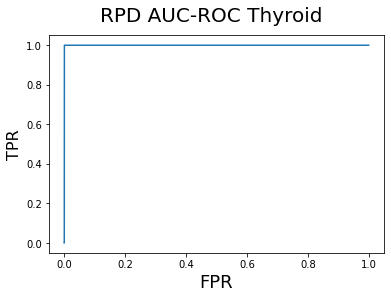

tree id: 2 tic time.
tic_datetime: 2021-12-10 20:40:29.285999
tic_datetime.strftime: 2021-12-10 20:40:29.285999
tic_walltime: 1639168829.2861385
tic_cpu: 15792.209864

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 2 tic time.
tic_datetime: 2021-12-10 20:40:30.441579
tic_datetime.strftime: 2021-12-10 20:40:30.441579
tic_walltime: 1639168830.441728
tic_cpu: 15793.366174



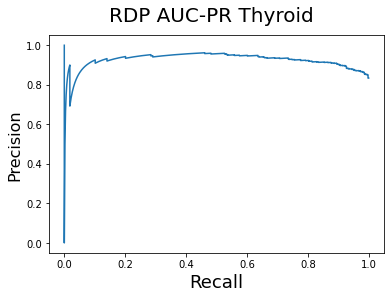

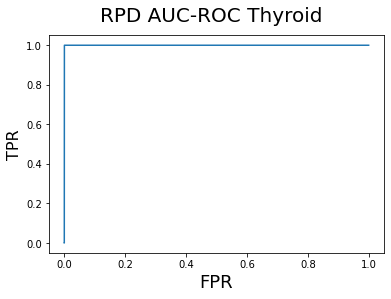

tree id: 3 tic time.
tic_datetime: 2021-12-10 20:40:30.906079
tic_datetime.strftime: 2021-12-10 20:40:30.906079
tic_walltime: 1639168830.9062498
tic_cpu: 15793.831219

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 3 tic time.
tic_datetime: 2021-12-10 20:40:32.060721
tic_datetime.strftime: 2021-12-10 20:40:32.060721
tic_walltime: 1639168832.0608788
tic_cpu: 15794.989823



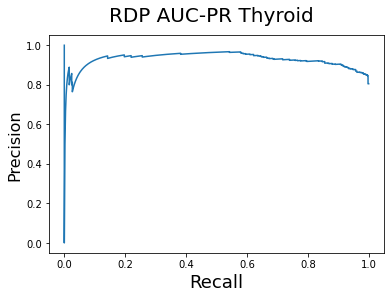

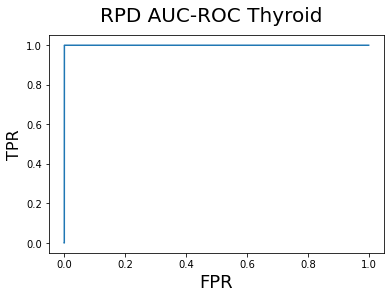

tree id: 4 tic time.
tic_datetime: 2021-12-10 20:40:32.523237
tic_datetime.strftime: 2021-12-10 20:40:32.523237
tic_walltime: 1639168832.524552
tic_cpu: 15795.456034

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 4 tic time.
tic_datetime: 2021-12-10 20:40:33.667638
tic_datetime.strftime: 2021-12-10 20:40:33.667638
tic_walltime: 1639168833.6684585
tic_cpu: 15796.604086



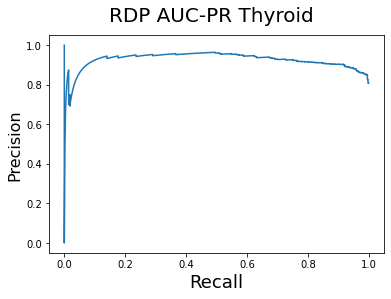

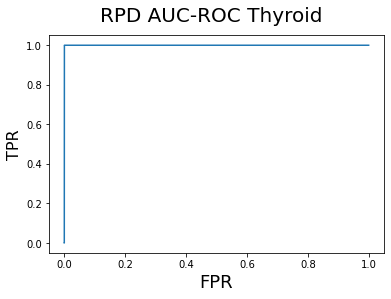

tree id: 5 tic time.
tic_datetime: 2021-12-10 20:40:34.145914
tic_datetime.strftime: 2021-12-10 20:40:34.145914
tic_walltime: 1639168834.147877
tic_cpu: 15797.093219

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 5 tic time.
tic_datetime: 2021-12-10 20:40:35.294145
tic_datetime.strftime: 2021-12-10 20:40:35.294145
tic_walltime: 1639168835.2949543
tic_cpu: 15798.242069



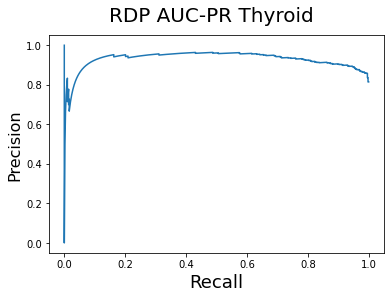

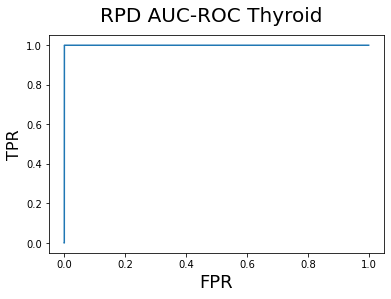

tree id: 6 tic time.
tic_datetime: 2021-12-10 20:40:35.760425
tic_datetime.strftime: 2021-12-10 20:40:35.760425
tic_walltime: 1639168835.7617993
tic_cpu: 15798.712346

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 6 tic time.
tic_datetime: 2021-12-10 20:40:36.906430
tic_datetime.strftime: 2021-12-10 20:40:36.906430
tic_walltime: 1639168836.9071956
tic_cpu: 15799.853097



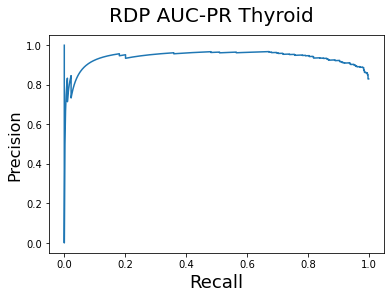

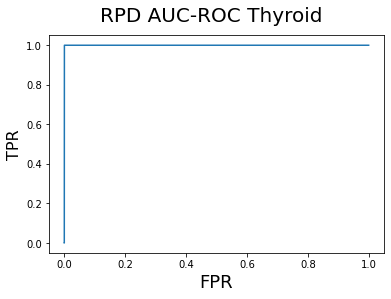

tree id: 7 tic time.
tic_datetime: 2021-12-10 20:40:37.377570
tic_datetime.strftime: 2021-12-10 20:40:37.377570
tic_walltime: 1639168837.3777196
tic_cpu: 15800.317957

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 7 tic time.
tic_datetime: 2021-12-10 20:40:38.534007
tic_datetime.strftime: 2021-12-10 20:40:38.534007
tic_walltime: 1639168838.5341766
tic_cpu: 15801.462845



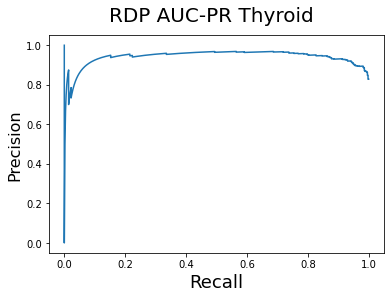

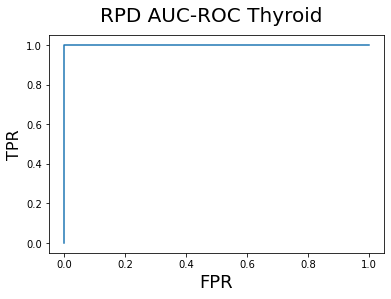

tree id: 8 tic time.
tic_datetime: 2021-12-10 20:40:39.010071
tic_datetime.strftime: 2021-12-10 20:40:39.010071
tic_walltime: 1639168839.0114837
tic_cpu: 15801.940055

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 8 tic time.
tic_datetime: 2021-12-10 20:40:40.166846
tic_datetime.strftime: 2021-12-10 20:40:40.166846
tic_walltime: 1639168840.1681402
tic_cpu: 15803.094029



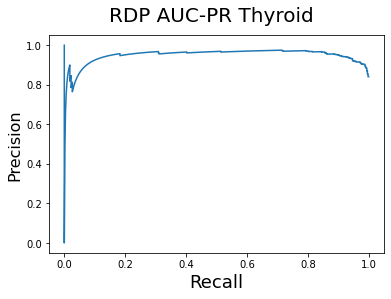

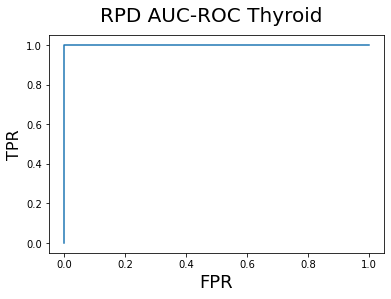

tree id: 9 tic time.
tic_datetime: 2021-12-10 20:40:40.782997
tic_datetime.strftime: 2021-12-10 20:40:40.782997
tic_walltime: 1639168840.7831686
tic_cpu: 15803.710509

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 9 tic time.
tic_datetime: 2021-12-10 20:40:41.939939
tic_datetime.strftime: 2021-12-10 20:40:41.939939
tic_walltime: 1639168841.9407644
tic_cpu: 15804.867398



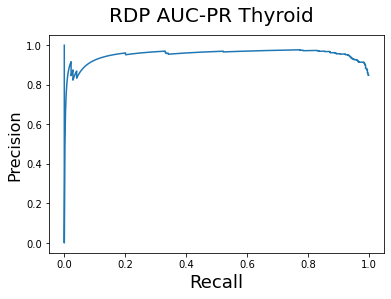

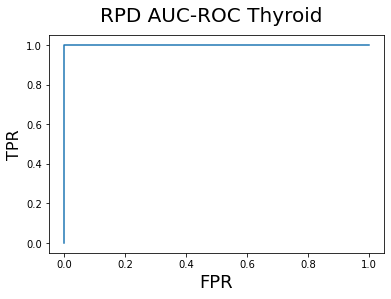

tree id: 10 tic time.
tic_datetime: 2021-12-10 20:40:42.412891
tic_datetime.strftime: 2021-12-10 20:40:42.412891
tic_walltime: 1639168842.4141824
tic_cpu: 15805.330447

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 10 tic time.
tic_datetime: 2021-12-10 20:40:43.577032
tic_datetime.strftime: 2021-12-10 20:40:43.577032
tic_walltime: 1639168843.5772157
tic_cpu: 15806.481068



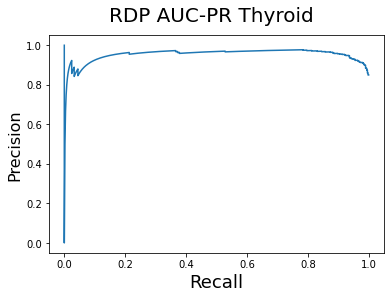

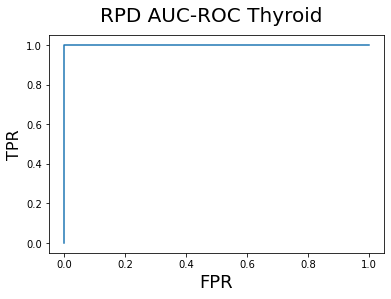

tree id: 11 tic time.
tic_datetime: 2021-12-10 20:40:44.065485
tic_datetime.strftime: 2021-12-10 20:40:44.065485
tic_walltime: 1639168844.0670226
tic_cpu: 15806.976655

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 11 tic time.
tic_datetime: 2021-12-10 20:40:45.229453
tic_datetime.strftime: 2021-12-10 20:40:45.229453
tic_walltime: 1639168845.2302241
tic_cpu: 15808.137153



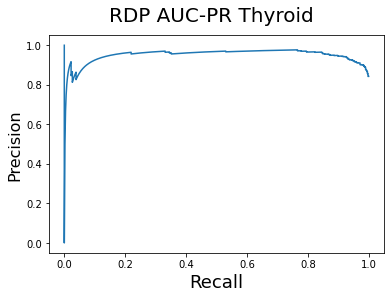

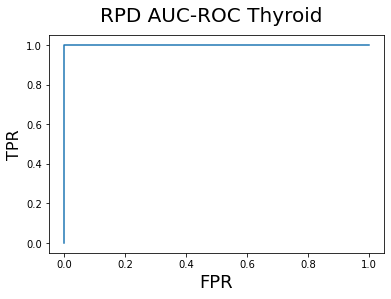

tree id: 12 tic time.
tic_datetime: 2021-12-10 20:40:45.694140
tic_datetime.strftime: 2021-12-10 20:40:45.694140
tic_walltime: 1639168845.6942978
tic_cpu: 15808.599755

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 12 tic time.
tic_datetime: 2021-12-10 20:40:46.844041
tic_datetime.strftime: 2021-12-10 20:40:46.844041
tic_walltime: 1639168846.84421
tic_cpu: 15809.748349



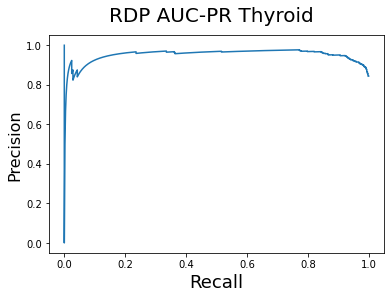

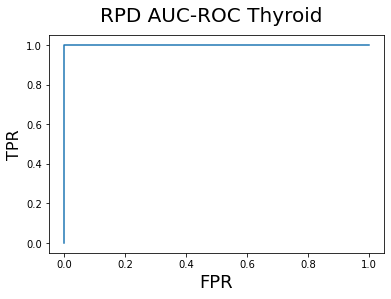

tree id: 13 tic time.
tic_datetime: 2021-12-10 20:40:47.331945
tic_datetime.strftime: 2021-12-10 20:40:47.331945
tic_walltime: 1639168847.3332438
tic_cpu: 15810.236469

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 13 tic time.
tic_datetime: 2021-12-10 20:40:48.477089
tic_datetime.strftime: 2021-12-10 20:40:48.477089
tic_walltime: 1639168848.4779031
tic_cpu: 15811.382239



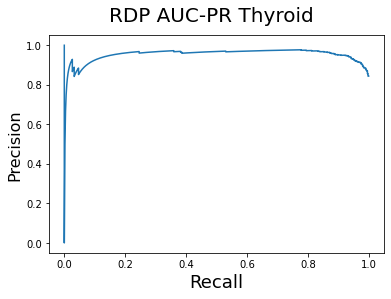

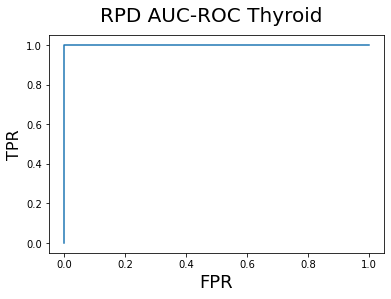

tree id: 14 tic time.
tic_datetime: 2021-12-10 20:40:48.939221
tic_datetime.strftime: 2021-12-10 20:40:48.939221
tic_walltime: 1639168848.9405262
tic_cpu: 15811.843776

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 14 tic time.
tic_datetime: 2021-12-10 20:40:50.105049
tic_datetime.strftime: 2021-12-10 20:40:50.105049
tic_walltime: 1639168850.1052094
tic_cpu: 15813.001295



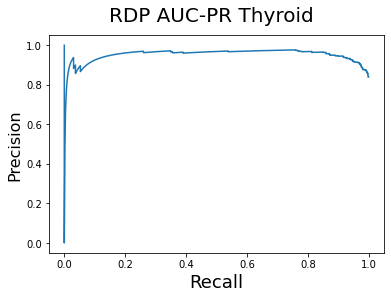

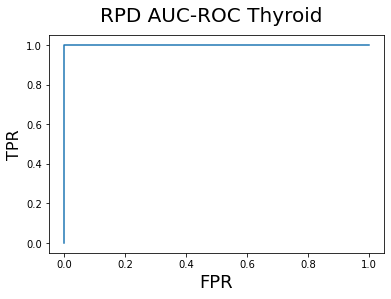

tree id: 15 tic time.
tic_datetime: 2021-12-10 20:40:50.572606
tic_datetime.strftime: 2021-12-10 20:40:50.572606
tic_walltime: 1639168850.5727272
tic_cpu: 15813.470192

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 15 tic time.
tic_datetime: 2021-12-10 20:40:51.718789
tic_datetime.strftime: 2021-12-10 20:40:51.718789
tic_walltime: 1639168851.719648
tic_cpu: 15814.619801



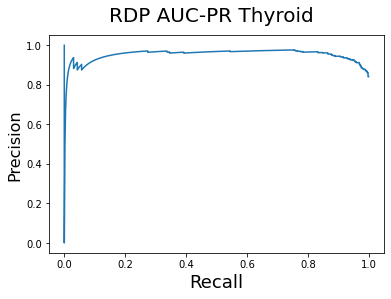

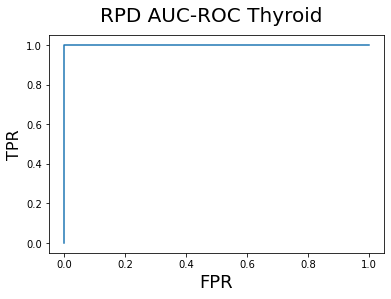

tree id: 16 tic time.
tic_datetime: 2021-12-10 20:40:52.192278
tic_datetime.strftime: 2021-12-10 20:40:52.192278
tic_walltime: 1639168852.1924047
tic_cpu: 15815.088758

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 16 tic time.
tic_datetime: 2021-12-10 20:40:53.337040
tic_datetime.strftime: 2021-12-10 20:40:53.337040
tic_walltime: 1639168853.337209
tic_cpu: 15816.236295



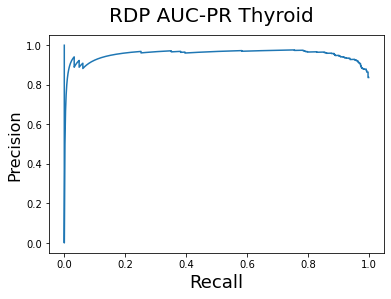

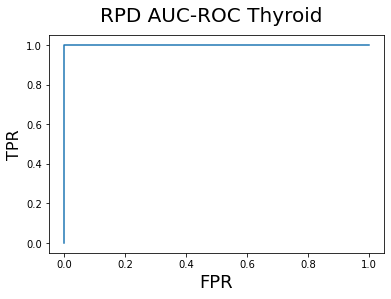

tree id: 17 tic time.
tic_datetime: 2021-12-10 20:40:53.805667
tic_datetime.strftime: 2021-12-10 20:40:53.805667
tic_walltime: 1639168853.8058047
tic_cpu: 15816.685641

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 17 tic time.
tic_datetime: 2021-12-10 20:40:54.972338
tic_datetime.strftime: 2021-12-10 20:40:54.972338
tic_walltime: 1639168854.9725032
tic_cpu: 15817.860451



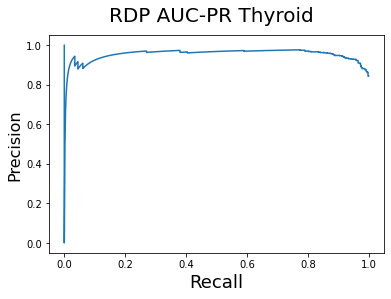

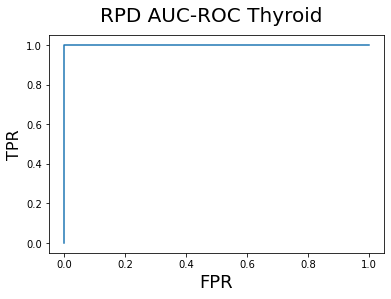

tree id: 18 tic time.
tic_datetime: 2021-12-10 20:40:55.441207
tic_datetime.strftime: 2021-12-10 20:40:55.441207
tic_walltime: 1639168855.4413362
tic_cpu: 15818.324299

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 18 tic time.
tic_datetime: 2021-12-10 20:40:56.598880
tic_datetime.strftime: 2021-12-10 20:40:56.598880
tic_walltime: 1639168856.5993018
tic_cpu: 15819.488131



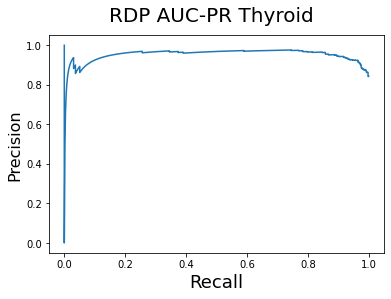

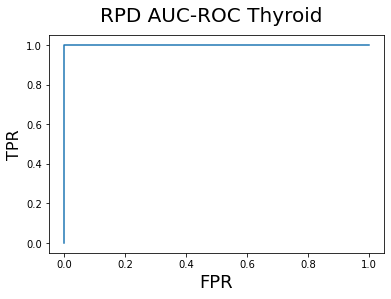

tree id: 19 tic time.
tic_datetime: 2021-12-10 20:40:57.235935
tic_datetime.strftime: 2021-12-10 20:40:57.235935
tic_walltime: 1639168857.2360847
tic_cpu: 15820.105159

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 19 tic time.
tic_datetime: 2021-12-10 20:40:58.396164
tic_datetime.strftime: 2021-12-10 20:40:58.396164
tic_walltime: 1639168858.3969285
tic_cpu: 15821.261586



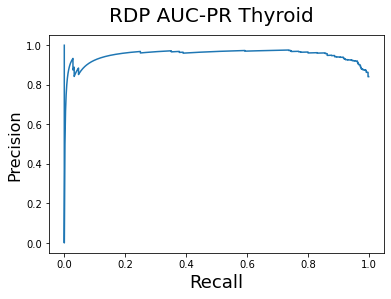

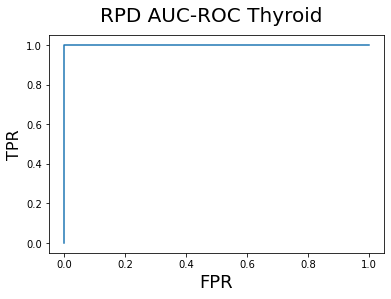

tree id: 20 tic time.
tic_datetime: 2021-12-10 20:40:58.857956
tic_datetime.strftime: 2021-12-10 20:40:58.857956
tic_walltime: 1639168858.8592842
tic_cpu: 15821.725628

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 20 tic time.
tic_datetime: 2021-12-10 20:41:00.012138
tic_datetime.strftime: 2021-12-10 20:41:00.012138
tic_walltime: 1639168860.012314
tic_cpu: 15822.871069



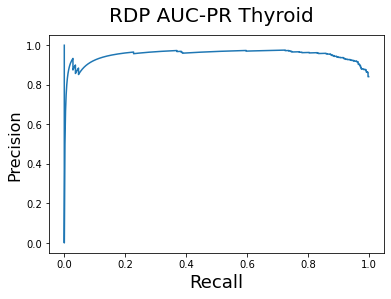

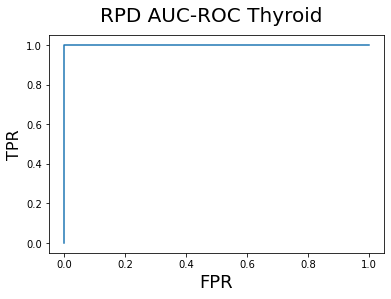

tree id: 21 tic time.
tic_datetime: 2021-12-10 20:41:00.513007
tic_datetime.strftime: 2021-12-10 20:41:00.513007
tic_walltime: 1639168860.5132236
tic_cpu: 15823.388472

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 21 tic time.
tic_datetime: 2021-12-10 20:41:01.672980
tic_datetime.strftime: 2021-12-10 20:41:01.672980
tic_walltime: 1639168861.673141
tic_cpu: 15824.550008



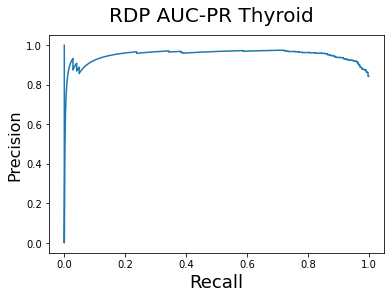

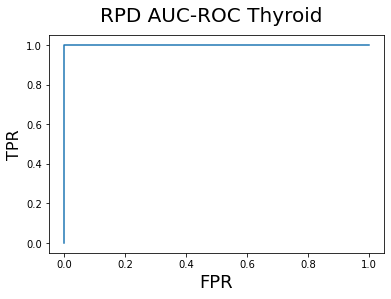

tree id: 22 tic time.
tic_datetime: 2021-12-10 20:41:02.154891
tic_datetime.strftime: 2021-12-10 20:41:02.154891
tic_walltime: 1639168862.155035
tic_cpu: 15825.023839

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 22 tic time.
tic_datetime: 2021-12-10 20:41:03.327042
tic_datetime.strftime: 2021-12-10 20:41:03.327042
tic_walltime: 1639168863.3272023
tic_cpu: 15826.187463



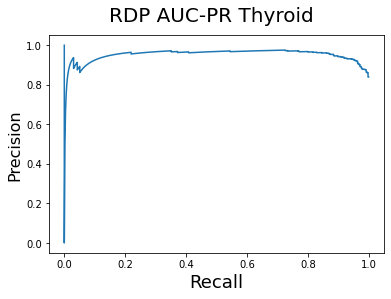

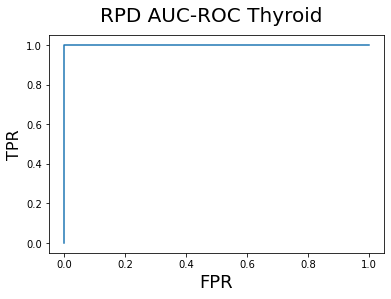

tree id: 23 tic time.
tic_datetime: 2021-12-10 20:41:03.793001
tic_datetime.strftime: 2021-12-10 20:41:03.793001
tic_walltime: 1639168863.793121
tic_cpu: 15826.655901

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 23 tic time.
tic_datetime: 2021-12-10 20:41:04.942413
tic_datetime.strftime: 2021-12-10 20:41:04.942413
tic_walltime: 1639168864.94629
tic_cpu: 15827.811936



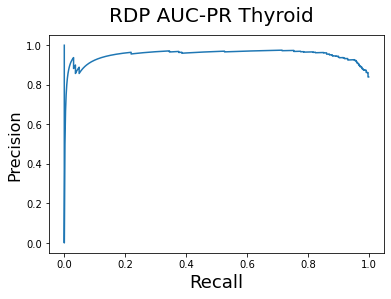

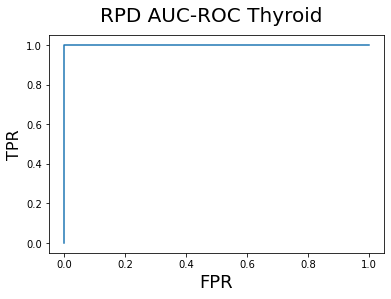

tree id: 24 tic time.
tic_datetime: 2021-12-10 20:41:05.438603
tic_datetime.strftime: 2021-12-10 20:41:05.438603
tic_walltime: 1639168865.4398825
tic_cpu: 15828.298685

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 24 tic time.
tic_datetime: 2021-12-10 20:41:06.590278
tic_datetime.strftime: 2021-12-10 20:41:06.590278
tic_walltime: 1639168866.5910454
tic_cpu: 15829.438524



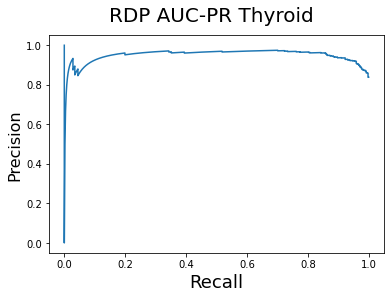

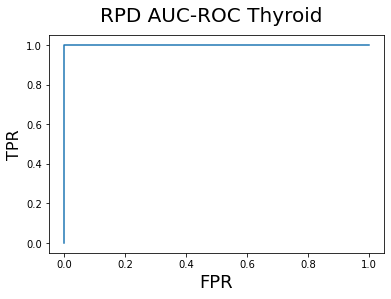

tree id: 25 tic time.
tic_datetime: 2021-12-10 20:41:07.065376
tic_datetime.strftime: 2021-12-10 20:41:07.065376
tic_walltime: 1639168867.0655324
tic_cpu: 15829.905944

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 25 tic time.
tic_datetime: 2021-12-10 20:41:08.230169
tic_datetime.strftime: 2021-12-10 20:41:08.230169
tic_walltime: 1639168868.2303522
tic_cpu: 15831.062068



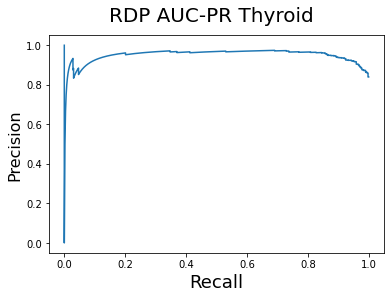

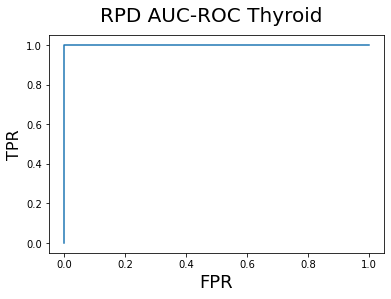

tree id: 26 tic time.
tic_datetime: 2021-12-10 20:41:08.687660
tic_datetime.strftime: 2021-12-10 20:41:08.687660
tic_walltime: 1639168868.689006
tic_cpu: 15831.52371

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 26 tic time.
tic_datetime: 2021-12-10 20:41:09.836337
tic_datetime.strftime: 2021-12-10 20:41:09.836337
tic_walltime: 1639168869.8364947
tic_cpu: 15832.671264



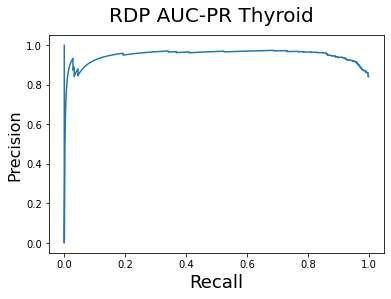

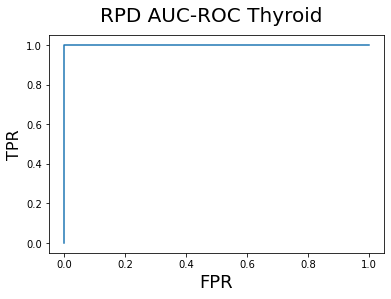

tree id: 27 tic time.
tic_datetime: 2021-12-10 20:41:10.310772
tic_datetime.strftime: 2021-12-10 20:41:10.310772
tic_walltime: 1639168870.310945
tic_cpu: 15833.136105

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 27 tic time.
tic_datetime: 2021-12-10 20:41:11.471395
tic_datetime.strftime: 2021-12-10 20:41:11.471395
tic_walltime: 1639168871.4721625
tic_cpu: 15834.299247



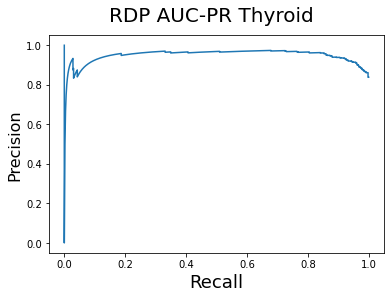

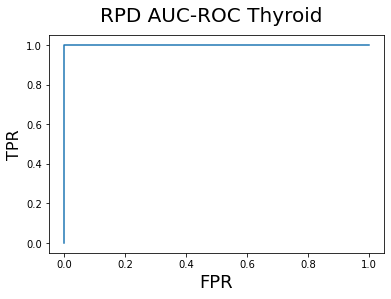

tree id: 28 tic time.
tic_datetime: 2021-12-10 20:41:11.934256
tic_datetime.strftime: 2021-12-10 20:41:11.934256
tic_walltime: 1639168871.9344263
tic_cpu: 15834.756713

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 28 tic time.
tic_datetime: 2021-12-10 20:41:13.095524
tic_datetime.strftime: 2021-12-10 20:41:13.095524
tic_walltime: 1639168873.0956903
tic_cpu: 15835.916267



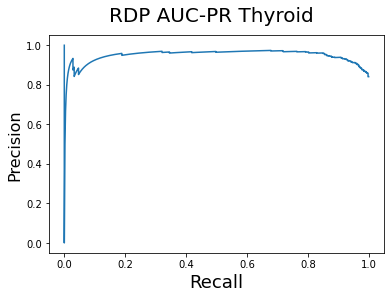

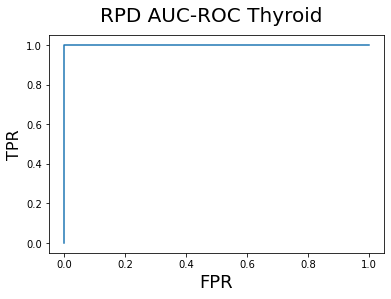

tree id: 29 tic time.
tic_datetime: 2021-12-10 20:41:13.582582
tic_datetime.strftime: 2021-12-10 20:41:13.582582
tic_walltime: 1639168873.5826943
tic_cpu: 15836.407469

RTargetNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.25, inplace=True)
  )
)
RNet(
  (layers): Sequential(
    (0): Linear(in_features=29, out_features=50, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc2): Linear(in_features=50, out_features=50, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


tree id: 29 tic time.
tic_datetime: 2021-12-10 20:41:14.740756
tic_datetime.strftime: 2021-12-10 20:41:14.740756
tic_walltime: 1639168874.7409492
tic_cpu: 15837.565625



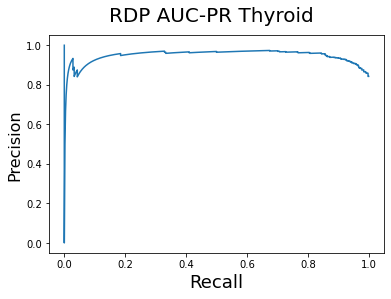

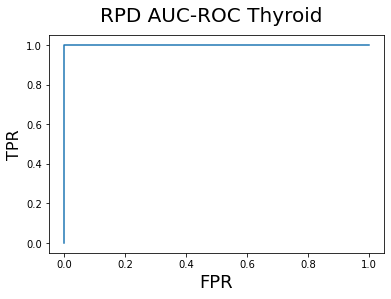

AUC-ROC: 1.0000, AUC-PR: 0.9470


In [ ]:
# this is the driver cell for RDP
# have all your data in your google drive in a folder called data
# to change the dataset you want to analyze change dataset

dataset='annthyroid_21feat_normalised.csv'
root='gdrive/MyDrive//CSCI5523GroupAnomalyProject/data/'
data_path = root+dataset
save_path = "save_model/"
log_path = "logs/log.log"
output='gdrive/MyDrive//CSCI5523GroupAnomalyProject/data/rdp_results.csv'

logfile = open(log_path, 'w')
node_batch = 30
node_epoch = 200  # epoch for a node training
eval_interval = 24
batch_size = 192
out_c = 50
USE_GPU = True
LR = 1e-1
tree_depth = 8
forest_Tnum = 30
filter_ratio = 0.05  # filter those with high anomaly scores
dropout_r = 0.1
random_size = 10000  # randomly choose 1024 size of data for training

if not torch.cuda.is_available():
    USE_GPU = False

# Set mode
dev_flag = True
if dev_flag:
    print("Running in DEV_MODE!")

load_path=save_path
out_c = 50

# count from 1
testing_methods_set = ['last_layer', 'first_layer', 'level']
testing_method = 1
USE_GPU = True
tree_depth = 8
forest_Tnum = 30
dropout_r = 0.1

if not torch.cuda.is_available():
    USE_GPU = False


train()  #data_path gets passed as a previously set "global"
test(output, dataset)  #data_path gets passed as a previously set "globl"